# Retrieve Skin Dataset and Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir data
! unzip -q skin-cancer-mnist-ham10000.zip -d data
! unzip -q /content/drive/MyDrive/HAM10000_segmentations_lesion_tschandl.zip -d data

mkdir: cannot create directory ‘data’: File exists
replace data/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace data/HAM10000_segmentations_lesion_tschandl/ISIC_0028777_segmentation.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
pip install -U albumentations

In [ ]:
import albumentations as A
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
from itertools import product
import torch.nn as nn
import copy
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn.functional as Fun
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Skin Dataset Information

## Image Processing Class

In [ ]:
class SkinCancerDataset(Dataset):
    """
    Args:
      dataframe (pd.DataFrame): DataFrame containing image information and labels.
      image_dirs (list): List of directories where images are stored.
      mask_dir (str): Directory where segmentation masks are stored.
      transform (callable, optional): Transformations to apply to the images.

    Methods:
      __init__(dataframe, image_dirs, mask_dir, transform=None):
        Initializes the dataset with the given parameters.

      __len__():
        Returns the number of samples in the dataset.

      apply_mask(image, mask):
        Returns a segmented image given an image and its mask.

      __getitem__(idx):
        Retrieves the image and label for a given index.

    """
    def __init__(self, dataframe, image_dirs, mask_dir, transform=None):
      self.dataframe = dataframe.reset_index(drop=True)
      self.image_dirs = image_dirs
      self.mask_dir = mask_dir
      self.transform = transform

    def __len__(self):
      return len(self.dataframe)

    # Bitwise multiplication on the image and the mask
    def apply_mask(self, image, mask):
      return image * np.expand_dims(mask, axis=0)

    def __getitem__(self, idx):
      img_id = self.dataframe.loc[idx, 'image_id']
      label = self.dataframe.loc[idx, 'dx_encoded']

      # Find image path
      img_path = None
      for dir in self.image_dirs:
        potential_path = os.path.join(dir, f"{img_id}.jpg")
        if os.path.exists(potential_path):
          img_path = potential_path
          break
      if img_path is None:
        raise FileNotFoundError(f"Image {img_id} not found in specified directories.")

      # Find mask path
      mask_path = os.path.join(self.mask_dir, f"{img_id}_segmentation.png")
      if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask for image {img_id} not found in {self.mask_dir}.")

      image = np.array(Image.open(img_path).convert('RGB'))
      mask = np.array(Image.open(mask_path).convert('L'))

      # Apply transformations to the image and the mask
      if self.transform:
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

      masked_image = self.apply_mask(image, mask)

      label = torch.tensor(label, dtype=torch.long)

      return image, label

## Image Augmentation Settings

In [ ]:
train_transform = A.Compose([
  A.HorizontalFlip(p=0.5),
  A.Rotate(limit=20, p=0.5),
  A.Resize(224, 224),
  A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ToTensorV2()
])

val_test_transform = A.Compose([
  A.Resize(224, 224),
  A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ToTensorV2()
])

## Metadata and Class Distribution

In [ ]:
DATA_DIR = 'data/'

METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_DIRS = [os.path.join(DATA_DIR, 'HAM10000_images_part_1'),
              os.path.join(DATA_DIR, 'HAM10000_images_part_2')]
MASK_DIR = os.path.join(DATA_DIR, 'HAM10000_segmentations_lesion_tschandl')

metadata = pd.read_csv(METADATA_FILE)

In [ ]:
le = LabelEncoder()
metadata['dx_encoded'] = le.fit_transform(metadata['dx'])
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(le.classes_)
print(metadata['image_id'])

Number of classes: 7
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object


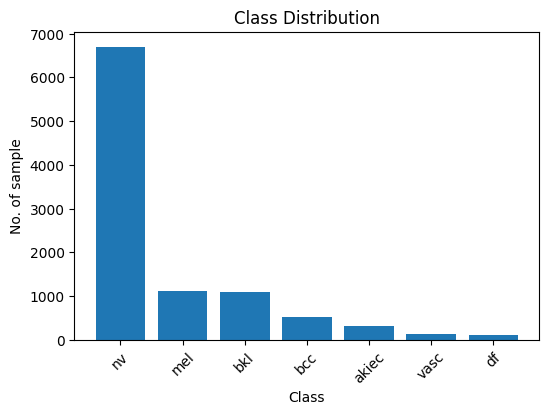

In [ ]:
class_counts = metadata['dx'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('No. of sample')
plt.xticks(rotation=45)
plt.show()

## Image and Mask Example

(-0.5, 599.5, 449.5, -0.5)

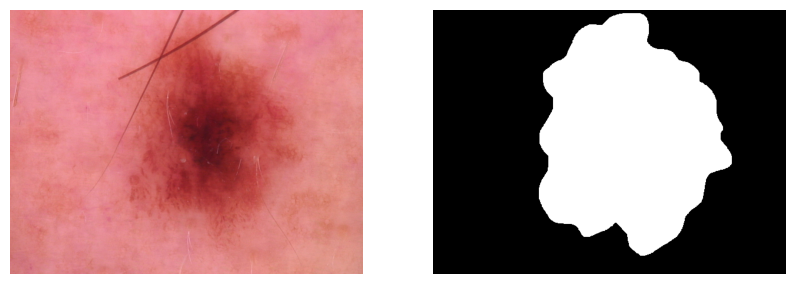

In [ ]:
example_image =  np.array(Image.open('data/HAM10000_images_part_1/ISIC_0024306.jpg').convert('RGB'))
example_mask =  np.array(Image.open('data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png').convert('RGB'))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(example_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(example_mask)
plt.axis('off')


# Training and Evaluating Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, preds = torch.max(outputs, 1)
    correct += torch.sum(preds == labels.data)
    total += labels.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct.double() / total

  return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      correct += torch.sum(preds == labels.data)
      total += labels.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct.double() / total

  return epoch_loss, epoch_acc

In [ ]:
def run_epoch(model, optimizer, criterion, train_loader, val_loader, scheduler=None):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  num_epochs = 30
  PATIENCE = 10
  patience_counter = 0

  for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training Phase
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Validation Phase
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Check if this is the best model so far
    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'best_alexnet.pth')
      print(f'Best model updated with Val Acc: {best_acc:.4f}')
      patience_counter = 0
    else:
      patience_counter += 1

    if patience_counter >= PATIENCE:
      print("Early stopping triggered.")
      break

    # Step the scheduler
    if scheduler:
      scheduler.step()

  print('\nTraining complete.')
  print(f'Best Validation Accuracy: {best_acc:.4f}')

  return best_acc

# Model Configuration

In [ ]:
def alexnet(lr, wd):
  model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
  model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
  model.eval()
  model = model.to(DEVICE)

  # Define optimizer and scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  return model, criterion, optimizer

# Hyperparameter Tuning

## Custom stratifiedKFold Class

In [ ]:
class stratifiedKFold:
  def __init__(self, n_split, shuffle, random_state):
    self.n_split = n_split
    self.shuffle = shuffle
    self.random_state = random_state

  def split(self, X, y):
    if (self.shuffle and self.random_state) is not None:
      np.random.seed(self.random_state)

    idx = np.arange(len(y))
    if self.shuffle:
      np.random.shuffle(idx)

    y_idx = defaultdict(list)
    for i, label in zip(idx, y):
      y_idx[label].append(i)

    splits = [[] for _ in range(self.n_split)]

    for label, i in y_idx.items():
      np.random.shuffle(i)
      split_portions = [len(i) // self.n_split] * self.n_split
      for j in range(len(i) % self.n_split):
        split_portions[j] += 1

      first = 0
      for k in range(self.n_split):
        last = first + split_portions[k]
        splits[k].extend(i[first:last])
        first = last

    for i in range(self.n_split):
      test_idx = splits[i]
      train_idx = np.concatenate([splits[j] for j in range(self.n_split) if j != i])
      yield train_idx, test_idx

    def get_n_splits(self):
      return self.n_split

## 5 x 3 Cross-Validation

In [ ]:
def cross_validate(X, y, hyperparameters):
  outer_fold = stratifiedKFold(n_split=5, shuffle=True, random_state=42)
  outer_results = []

  # outer fold
  for train_idx, test_idx in outer_fold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    inner_fold = stratifiedKFold(n_split=3, shuffle=True, random_state=42)
    best_acc = 0.0
    best_params = None

    for param in hyperparameters:
      lr = param['Lr']
      wd = param['weight_decay']
      BATCH_SIZE = param['batch_size']

      inner_acc = []

      # inner fold
      for inner_train_idx, inner_val_idx in inner_fold.split(X_train, y_train):
        X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]

        model, criterion, optimizer = alexnet(lr, wd)

        train_dataset = SkinCancerDataset(X_inner_train, IMAGE_DIRS, MASK_DIR, transform=train_transform)
        val_dataset = SkinCancerDataset(X_inner_val, IMAGE_DIRS, MASK_DIR, transform=val_test_transform)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

        best_inner_acc = run_epoch(model, optimizer, criterion, train_loader, val_loader)
        inner_acc.append(best_inner_acc)

      inner_acc = [acc.cpu().numpy() for acc in inner_acc]
      mean_inner_acc = np.mean(inner_acc)

      # Update best score and parameters
      if mean_inner_acc > best_acc:
        best_acc = mean_inner_acc
        best_params = param
        print(best_params)

      # Retrain the model with the best parameters on the entire outer training set
      lr = best_params['Lr']
      wd = best_params['weight_decay']
      BATCH_SIZE = best_params['batch_size']

      model, criterion, optimizer = alexnet(lr, wd)

      train_dataset = SkinCancerDataset(X_train, IMAGE_DIRS, MASK_DIR, transform=train_transform)
      test_dataset = SkinCancerDataset(X_test, IMAGE_DIRS, MASK_DIR, transform=val_test_transform)

      train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
      test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

      best_outer_acc = run_epoch(model, optimizer, criterion, train_loader, test_loader)

      outer_results.append((best_params, best_outer_acc))

  hyper_result = []
  for params, acc in outer_results:
    hyper_result.append({'Lr': params['Lr'], 'weight_decay': params['weight_decay'],
                         'batch_size': params['batch_size'], 'accuracy': acc.item()})

  hyper_df = pd.DataFrame(hyper_result)
  file_path = 'drive/MyDrive/hyper_result.csv'
  hyper_df.to_csv(file_path, index=False)

  return outer_results

## Custom Stratified Data Extraction

In [ ]:
# The extracted data size is determined by the portion parameter
def stratified_extracted_dataset(dataset, target, portion=0.2):
  n_samples = int(len(target) * portion)

  y_idx = defaultdict(list)
  for i, label in enumerate(target):
    y_idx[label].append(i)

  extracted_indices = []

  for label, indices in y_idx.items():
    np.random.shuffle(indices)
    n_per_class = min(len(indices), n_samples // len(y_idx))
    extracted_indices.extend(indices[:n_per_class])

  return dataset.loc[extracted_indices]

## Hyperparameter Tuning Execution

In [ ]:
extracted = stratified_extracted_dataset(metadata, metadata['dx_encoded'], portion = 0.5)

In [ ]:
hyperparameters = [
  {'Lr' : 1e-5, 'batch_size' : 64, 'weight_decay' : 1e-4},
  {'Lr' : 1e-4, 'batch_size' : 128, 'weight_decay' : 1e-4},
  {'Lr' : 5e-4, 'batch_size' : 256, 'weight_decay' : 5e-4},
]

hyper_tuning_result = cross_validate(extracted, extracted['dx_encoded'], hyperparameters)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/30
----------
Train Loss: 1.8354 Acc: 0.2416
Val Loss: 1.6448 Acc: 0.3576
Best model updated with Val Acc: 0.3576

Epoch 2/30
----------
Train Loss: 1.5568 Acc: 0.3963
Val Loss: 1.4568 Acc: 0.4371
Best model updated with Val Acc: 0.4371

Epoch 3/30
----------
Train Loss: 1.3833 Acc: 0.4496
Val Loss: 1.3133 Acc: 0.4902
Best model updated with Val Acc: 0.4902

Epoch 4/30
----------
Train Loss: 1.2464 Acc: 0.5220
Val Loss: 1.2022 Acc: 0.5433
Best model updated with Val Acc: 0.5433

Epoch 5/30
----------
Train Loss: 1.1337 Acc: 0.5747
Val Loss: 1.1133 Acc: 0.5790
Best model updated with Val Acc: 0.5790

Epoch 6/30
----------
Train Loss: 1.0582 Acc: 0.5939
Val Loss: 1.0607 Acc: 0.5802
Best model updated with Val Acc: 0.5802

Epoch 7/30
----------
Train Loss: 0.9949 Acc: 0.6072
Val Loss: 1.0151 Acc: 0.6067
Best model updated with Val Acc: 0.6067

Epoch 8/30
----------
Train Loss: 0.9193 Acc: 0.6414
Val Loss: 0.9974 Acc: 0.6136
Best model updated with Val Acc: 0.6136

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8549 Acc: 0.2269
Val Loss: 1.6290 Acc: 0.3630
Best model updated with Val Acc: 0.3630

Epoch 2/30
----------
Train Loss: 1.5285 Acc: 0.4097
Val Loss: 1.4358 Acc: 0.4486
Best model updated with Val Acc: 0.4486

Epoch 3/30
----------
Train Loss: 1.3461 Acc: 0.4786
Val Loss: 1.2914 Acc: 0.4925
Best model updated with Val Acc: 0.4925

Epoch 4/30
----------
Train Loss: 1.2309 Acc: 0.5336
Val Loss: 1.1806 Acc: 0.5168
Best model updated with Val Acc: 0.5168

Epoch 5/30
----------
Train Loss: 1.1181 Acc: 0.5729
Val Loss: 1.1018 Acc: 0.5653
Best model updated with Val Acc: 0.5653

Epoch 6/30
----------
Train Loss: 1.0356 Acc: 0.6094
Val Loss: 1.0395 Acc: 0.5954
Best model updated with Val Acc: 0.5954

Epoch 7/30
----------
Train Loss: 0.9867 Acc: 0.6319
Val Loss: 0.9925 Acc: 0.6277
Best model updated with Val Acc: 0.6277

Epoch 8/30
----------
Train Loss: 0.8991 Acc: 0.6603
Val Loss: 0.9689 Acc: 0.6324
Best model updated with Val Acc: 0.6324

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8327 Acc: 0.2604
Val Loss: 1.5870 Acc: 0.4309
Best model updated with Val Acc: 0.4309

Epoch 2/30
----------
Train Loss: 1.5104 Acc: 0.4376
Val Loss: 1.4016 Acc: 0.4832
Best model updated with Val Acc: 0.4832

Epoch 3/30
----------
Train Loss: 1.3241 Acc: 0.5064
Val Loss: 1.2844 Acc: 0.5424
Best model updated with Val Acc: 0.5424

Epoch 4/30
----------
Train Loss: 1.1967 Acc: 0.5641
Val Loss: 1.1944 Acc: 0.5656
Best model updated with Val Acc: 0.5656

Epoch 5/30
----------
Train Loss: 1.1064 Acc: 0.5872
Val Loss: 1.1194 Acc: 0.5970
Best model updated with Val Acc: 0.5970

Epoch 6/30
----------
Train Loss: 1.0079 Acc: 0.6351
Val Loss: 1.1033 Acc: 0.5912

Epoch 7/30
----------
Train Loss: 0.9688 Acc: 0.6328
Val Loss: 1.0487 Acc: 0.6190
Best model updated with Val Acc: 0.6190

Epoch 8/30
----------
Train Loss: 0.9057 Acc: 0.6536
Val Loss: 1.0015 Acc: 0.6272
Best model updated with Val Acc: 0.6272

Epoch 9/30
----------
Train Loss: 0.8588 Acc: 0.6755
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5742 Acc: 0.3720
Val Loss: 1.2438 Acc: 0.5294
Best model updated with Val Acc: 0.5294

Epoch 2/30
----------
Train Loss: 1.1231 Acc: 0.5666
Val Loss: 1.0663 Acc: 0.5871
Best model updated with Val Acc: 0.5871

Epoch 3/30
----------
Train Loss: 0.9039 Acc: 0.6524
Val Loss: 0.9814 Acc: 0.6159
Best model updated with Val Acc: 0.6159

Epoch 4/30
----------
Train Loss: 0.7676 Acc: 0.7057
Val Loss: 0.9446 Acc: 0.6321
Best model updated with Val Acc: 0.6321

Epoch 5/30
----------
Train Loss: 0.6834 Acc: 0.7439
Val Loss: 0.9297 Acc: 0.6528
Best model updated with Val Acc: 0.6528

Epoch 6/30
----------
Train Loss: 0.5656 Acc: 0.7845
Val Loss: 0.8389 Acc: 0.6943
Best model updated with Val Acc: 0.6943

Epoch 7/30
----------
Train Loss: 0.4849 Acc: 0.8169
Val Loss: 0.9167 Acc: 0.6817

Epoch 8/30
----------
Train Loss: 0.4190 Acc: 0.8436
Val Loss: 0.9612 Acc: 0.6701

Epoch 9/30
----------
Train Loss: 0.3533 Acc: 0.8691
Val Loss: 0.9411 Acc: 0.6747

Epoch 10/30


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5402 Acc: 0.3889
Val Loss: 1.2451 Acc: 0.5457
Best model updated with Val Acc: 0.5457

Epoch 2/30
----------
Train Loss: 1.1216 Acc: 0.5648
Val Loss: 1.0208 Acc: 0.6116
Best model updated with Val Acc: 0.6116

Epoch 3/30
----------
Train Loss: 0.9326 Acc: 0.6557
Val Loss: 0.9685 Acc: 0.6301
Best model updated with Val Acc: 0.6301

Epoch 4/30
----------
Train Loss: 0.7803 Acc: 0.6950
Val Loss: 0.9230 Acc: 0.6497
Best model updated with Val Acc: 0.6497

Epoch 5/30
----------
Train Loss: 0.6747 Acc: 0.7529
Val Loss: 0.8995 Acc: 0.6636
Best model updated with Val Acc: 0.6636

Epoch 6/30
----------
Train Loss: 0.5948 Acc: 0.7853
Val Loss: 0.8798 Acc: 0.6786
Best model updated with Val Acc: 0.6786

Epoch 7/30
----------
Train Loss: 0.4970 Acc: 0.8137
Val Loss: 0.8943 Acc: 0.6994
Best model updated with Val Acc: 0.6994

Epoch 8/30
----------
Train Loss: 0.4022 Acc: 0.8617
Val Loss: 0.8467 Acc: 0.7029
Best model updated with Val Acc: 0.7029

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5128 Acc: 0.4261
Val Loss: 1.2364 Acc: 0.5308
Best model updated with Val Acc: 0.5308

Epoch 2/30
----------
Train Loss: 1.0588 Acc: 0.5958
Val Loss: 1.0367 Acc: 0.5947
Best model updated with Val Acc: 0.5947

Epoch 3/30
----------
Train Loss: 0.8742 Acc: 0.6611
Val Loss: 0.9833 Acc: 0.6469
Best model updated with Val Acc: 0.6469

Epoch 4/30
----------
Train Loss: 0.7426 Acc: 0.7182
Val Loss: 0.9281 Acc: 0.6655
Best model updated with Val Acc: 0.6655

Epoch 5/30
----------
Train Loss: 0.6446 Acc: 0.7598
Val Loss: 0.8841 Acc: 0.6690
Best model updated with Val Acc: 0.6690

Epoch 6/30
----------
Train Loss: 0.5532 Acc: 0.7979
Val Loss: 0.9087 Acc: 0.6585

Epoch 7/30
----------
Train Loss: 0.4612 Acc: 0.8216
Val Loss: 0.9572 Acc: 0.6690

Epoch 8/30
----------
Train Loss: 0.3894 Acc: 0.8528
Val Loss: 0.9294 Acc: 0.6655

Epoch 9/30
----------
Train Loss: 0.3694 Acc: 0.8585
Val Loss: 1.1371 Acc: 0.6609

Epoch 10/30
----------
Train Loss: 0.3310 Acc: 0.881

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9319 Acc: 0.2491
Val Loss: 1.6150 Acc: 0.3749
Best model updated with Val Acc: 0.3749

Epoch 2/30
----------
Train Loss: 1.5604 Acc: 0.4183
Val Loss: 1.3933 Acc: 0.4475
Best model updated with Val Acc: 0.4475

Epoch 3/30
----------
Train Loss: 1.4350 Acc: 0.4392
Val Loss: 1.3257 Acc: 0.4821
Best model updated with Val Acc: 0.4821

Epoch 4/30
----------
Train Loss: 1.2915 Acc: 0.4942
Val Loss: 1.2744 Acc: 0.5017
Best model updated with Val Acc: 0.5017

Epoch 5/30
----------
Train Loss: 1.1839 Acc: 0.5632
Val Loss: 1.2226 Acc: 0.5386
Best model updated with Val Acc: 0.5386

Epoch 6/30
----------
Train Loss: 1.1224 Acc: 0.5545
Val Loss: 1.1787 Acc: 0.5202

Epoch 7/30
----------
Train Loss: 1.0329 Acc: 0.5956
Val Loss: 1.0927 Acc: 0.5779
Best model updated with Val Acc: 0.5779

Epoch 8/30
----------
Train Loss: 0.9379 Acc: 0.6344
Val Loss: 1.0260 Acc: 0.5975
Best model updated with Val Acc: 0.5975

Epoch 9/30
----------
Train Loss: 0.9074 Acc: 0.6553
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8492 Acc: 0.2581
Val Loss: 1.6099 Acc: 0.3723
Best model updated with Val Acc: 0.3723

Epoch 2/30
----------
Train Loss: 1.4722 Acc: 0.4369
Val Loss: 1.4276 Acc: 0.4624
Best model updated with Val Acc: 0.4624

Epoch 3/30
----------
Train Loss: 1.3198 Acc: 0.4797
Val Loss: 1.2671 Acc: 0.5052
Best model updated with Val Acc: 0.5052

Epoch 4/30
----------
Train Loss: 1.1690 Acc: 0.5451
Val Loss: 1.1737 Acc: 0.5514
Best model updated with Val Acc: 0.5514

Epoch 5/30
----------
Train Loss: 1.0695 Acc: 0.6059
Val Loss: 1.1205 Acc: 0.5815
Best model updated with Val Acc: 0.5815

Epoch 6/30
----------
Train Loss: 0.9870 Acc: 0.6175
Val Loss: 1.0962 Acc: 0.6012
Best model updated with Val Acc: 0.6012

Epoch 7/30
----------
Train Loss: 0.9196 Acc: 0.6499
Val Loss: 1.0429 Acc: 0.5988

Epoch 8/30
----------
Train Loss: 0.8680 Acc: 0.6736
Val Loss: 1.0104 Acc: 0.6486
Best model updated with Val Acc: 0.6486

Epoch 9/30
----------
Train Loss: 0.7654 Acc: 0.7037
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7120 Acc: 0.3268
Val Loss: 1.3368 Acc: 0.4959
Best model updated with Val Acc: 0.4959

Epoch 2/30
----------
Train Loss: 1.2948 Acc: 0.5191
Val Loss: 1.2958 Acc: 0.5157
Best model updated with Val Acc: 0.5157

Epoch 3/30
----------
Train Loss: 1.1300 Acc: 0.5704
Val Loss: 1.1684 Acc: 0.5517
Best model updated with Val Acc: 0.5517

Epoch 4/30
----------
Train Loss: 0.9698 Acc: 0.6282
Val Loss: 1.1001 Acc: 0.5970
Best model updated with Val Acc: 0.5970

Epoch 5/30
----------
Train Loss: 0.8379 Acc: 0.6801
Val Loss: 1.0123 Acc: 0.5958

Epoch 6/30
----------
Train Loss: 0.7412 Acc: 0.7096
Val Loss: 0.9892 Acc: 0.6307
Best model updated with Val Acc: 0.6307

Epoch 7/30
----------
Train Loss: 0.6048 Acc: 0.7737
Val Loss: 1.0080 Acc: 0.6423
Best model updated with Val Acc: 0.6423

Epoch 8/30
----------
Train Loss: 0.5712 Acc: 0.7800
Val Loss: 1.1495 Acc: 0.6237

Epoch 9/30
----------
Train Loss: 0.5362 Acc: 0.8031
Val Loss: 1.1465 Acc: 0.6341

Epoch 10/30


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.3435 Acc: 0.4805
Val Loss: 1.0835 Acc: 0.5815
Best model updated with Val Acc: 0.5815

Epoch 2/30
----------
Train Loss: 0.9898 Acc: 0.6209
Val Loss: 0.9760 Acc: 0.6385
Best model updated with Val Acc: 0.6385

Epoch 3/30
----------
Train Loss: 0.8320 Acc: 0.6895
Val Loss: 0.9556 Acc: 0.6338

Epoch 4/30
----------
Train Loss: 0.7131 Acc: 0.7273
Val Loss: 0.8711 Acc: 0.6738
Best model updated with Val Acc: 0.6738

Epoch 5/30
----------
Train Loss: 0.6019 Acc: 0.7748
Val Loss: 0.8525 Acc: 0.6785
Best model updated with Val Acc: 0.6785

Epoch 6/30
----------
Train Loss: 0.5401 Acc: 0.7975
Val Loss: 0.8146 Acc: 0.7185
Best model updated with Val Acc: 0.7185

Epoch 7/30
----------
Train Loss: 0.4654 Acc: 0.8180
Val Loss: 0.8636 Acc: 0.7308
Best model updated with Val Acc: 0.7308

Epoch 8/30
----------
Train Loss: 0.4030 Acc: 0.8569
Val Loss: 0.9157 Acc: 0.7015

Epoch 9/30
----------
Train Loss: 0.3479 Acc: 0.8704
Val Loss: 0.8652 Acc: 0.7385
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7492 Acc: 0.3105
Val Loss: 1.5353 Acc: 0.3910
Best model updated with Val Acc: 0.3910

Epoch 2/30
----------
Train Loss: 1.4683 Acc: 0.4334
Val Loss: 1.3703 Acc: 0.4706
Best model updated with Val Acc: 0.4706

Epoch 3/30
----------
Train Loss: 1.2991 Acc: 0.5081
Val Loss: 1.2612 Acc: 0.5248
Best model updated with Val Acc: 0.5248

Epoch 4/30
----------
Train Loss: 1.1851 Acc: 0.5718
Val Loss: 1.1831 Acc: 0.5594
Best model updated with Val Acc: 0.5594

Epoch 5/30
----------
Train Loss: 1.0482 Acc: 0.6153
Val Loss: 1.1220 Acc: 0.5617
Best model updated with Val Acc: 0.5617

Epoch 6/30
----------
Train Loss: 0.9928 Acc: 0.6379
Val Loss: 1.0855 Acc: 0.5790
Best model updated with Val Acc: 0.5790

Epoch 7/30
----------
Train Loss: 0.9277 Acc: 0.6547
Val Loss: 1.0464 Acc: 0.6090
Best model updated with Val Acc: 0.6090

Epoch 8/30
----------
Train Loss: 0.8672 Acc: 0.6773
Val Loss: 1.0136 Acc: 0.6251
Best model updated with Val Acc: 0.6251

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8146 Acc: 0.2841
Val Loss: 1.6224 Acc: 0.4012
Best model updated with Val Acc: 0.4012

Epoch 2/30
----------
Train Loss: 1.5192 Acc: 0.4369
Val Loss: 1.4300 Acc: 0.4821
Best model updated with Val Acc: 0.4821

Epoch 3/30
----------
Train Loss: 1.3467 Acc: 0.5029
Val Loss: 1.2986 Acc: 0.5087
Best model updated with Val Acc: 0.5087

Epoch 4/30
----------
Train Loss: 1.2469 Acc: 0.5312
Val Loss: 1.1950 Acc: 0.5595
Best model updated with Val Acc: 0.5595

Epoch 5/30
----------
Train Loss: 1.1347 Acc: 0.5706
Val Loss: 1.1096 Acc: 0.5815
Best model updated with Val Acc: 0.5815

Epoch 6/30
----------
Train Loss: 1.0654 Acc: 0.6053
Val Loss: 1.0435 Acc: 0.6139
Best model updated with Val Acc: 0.6139

Epoch 7/30
----------
Train Loss: 1.0049 Acc: 0.6105
Val Loss: 1.0131 Acc: 0.6127

Epoch 8/30
----------
Train Loss: 0.9377 Acc: 0.6453
Val Loss: 0.9528 Acc: 0.6289
Best model updated with Val Acc: 0.6289

Epoch 9/30
----------
Train Loss: 0.8886 Acc: 0.6684
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7084 Acc: 0.3418
Val Loss: 1.5018 Acc: 0.4286
Best model updated with Val Acc: 0.4286

Epoch 2/30
----------
Train Loss: 1.4426 Acc: 0.4480
Val Loss: 1.3446 Acc: 0.4750
Best model updated with Val Acc: 0.4750

Epoch 3/30
----------
Train Loss: 1.3014 Acc: 0.5029
Val Loss: 1.2443 Acc: 0.5482
Best model updated with Val Acc: 0.5482

Epoch 4/30
----------
Train Loss: 1.1798 Acc: 0.5589
Val Loss: 1.1636 Acc: 0.5679
Best model updated with Val Acc: 0.5679

Epoch 5/30
----------
Train Loss: 1.0988 Acc: 0.5843
Val Loss: 1.1186 Acc: 0.5865
Best model updated with Val Acc: 0.5865

Epoch 6/30
----------
Train Loss: 1.0224 Acc: 0.6149
Val Loss: 1.0767 Acc: 0.6005
Best model updated with Val Acc: 0.6005

Epoch 7/30
----------
Train Loss: 0.9409 Acc: 0.6386
Val Loss: 1.0439 Acc: 0.6086
Best model updated with Val Acc: 0.6086

Epoch 8/30
----------
Train Loss: 0.9088 Acc: 0.6547
Val Loss: 1.0557 Acc: 0.5981

Epoch 9/30
----------
Train Loss: 0.8815 Acc: 0.6594
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.4742 Acc: 0.4247
Val Loss: 1.2606 Acc: 0.5329
Best model updated with Val Acc: 0.5329

Epoch 2/30
----------
Train Loss: 1.0612 Acc: 0.5869
Val Loss: 1.0551 Acc: 0.6021
Best model updated with Val Acc: 0.6021

Epoch 3/30
----------
Train Loss: 0.8607 Acc: 0.6680
Val Loss: 1.0292 Acc: 0.6159
Best model updated with Val Acc: 0.6159

Epoch 4/30
----------
Train Loss: 0.7342 Acc: 0.7265
Val Loss: 0.9887 Acc: 0.6309
Best model updated with Val Acc: 0.6309

Epoch 5/30
----------
Train Loss: 0.6258 Acc: 0.7683
Val Loss: 0.9377 Acc: 0.6494
Best model updated with Val Acc: 0.6494

Epoch 6/30
----------
Train Loss: 0.5308 Acc: 0.8001
Val Loss: 0.9685 Acc: 0.6609
Best model updated with Val Acc: 0.6609

Epoch 7/30
----------
Train Loss: 0.4443 Acc: 0.8424
Val Loss: 1.1396 Acc: 0.6609

Epoch 8/30
----------
Train Loss: 0.4063 Acc: 0.8476
Val Loss: 1.1003 Acc: 0.6574

Epoch 9/30
----------
Train Loss: 0.3822 Acc: 0.8644
Val Loss: 1.0518 Acc: 0.6701
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5591 Acc: 0.3935
Val Loss: 1.2051 Acc: 0.5364
Best model updated with Val Acc: 0.5364

Epoch 2/30
----------
Train Loss: 1.1451 Acc: 0.5608
Val Loss: 1.0074 Acc: 0.6243
Best model updated with Val Acc: 0.6243

Epoch 3/30
----------
Train Loss: 0.9214 Acc: 0.6516
Val Loss: 0.9183 Acc: 0.6405
Best model updated with Val Acc: 0.6405

Epoch 4/30
----------
Train Loss: 0.7665 Acc: 0.7089
Val Loss: 0.8437 Acc: 0.6960
Best model updated with Val Acc: 0.6960

Epoch 5/30
----------
Train Loss: 0.6703 Acc: 0.7436
Val Loss: 0.9421 Acc: 0.6208

Epoch 6/30
----------
Train Loss: 0.5757 Acc: 0.7847
Val Loss: 0.8408 Acc: 0.6971
Best model updated with Val Acc: 0.6971

Epoch 7/30
----------
Train Loss: 0.4860 Acc: 0.8218
Val Loss: 0.8109 Acc: 0.7145
Best model updated with Val Acc: 0.7145

Epoch 8/30
----------
Train Loss: 0.4138 Acc: 0.8472
Val Loss: 0.9265 Acc: 0.6890

Epoch 9/30
----------
Train Loss: 0.3674 Acc: 0.8513
Val Loss: 0.8380 Acc: 0.7260
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5279 Acc: 0.4042
Val Loss: 1.2152 Acc: 0.5447
Best model updated with Val Acc: 0.5447

Epoch 2/30
----------
Train Loss: 1.0784 Acc: 0.5756
Val Loss: 1.0637 Acc: 0.5830
Best model updated with Val Acc: 0.5830

Epoch 3/30
----------
Train Loss: 0.8760 Acc: 0.6599
Val Loss: 0.9743 Acc: 0.6121
Best model updated with Val Acc: 0.6121

Epoch 4/30
----------
Train Loss: 0.7492 Acc: 0.7200
Val Loss: 0.9515 Acc: 0.6492
Best model updated with Val Acc: 0.6492

Epoch 5/30
----------
Train Loss: 0.6523 Acc: 0.7465
Val Loss: 0.9122 Acc: 0.6609
Best model updated with Val Acc: 0.6609

Epoch 6/30
----------
Train Loss: 0.5553 Acc: 0.7979
Val Loss: 0.9932 Acc: 0.6655
Best model updated with Val Acc: 0.6655

Epoch 7/30
----------
Train Loss: 0.5231 Acc: 0.8112
Val Loss: 0.9318 Acc: 0.6551

Epoch 8/30
----------
Train Loss: 0.4179 Acc: 0.8430
Val Loss: 0.9356 Acc: 0.6829
Best model updated with Val Acc: 0.6829

Epoch 9/30
----------
Train Loss: 0.3589 Acc: 0.8655
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8614 Acc: 0.2740
Val Loss: 1.6175 Acc: 0.3564
Best model updated with Val Acc: 0.3564

Epoch 2/30
----------
Train Loss: 1.4920 Acc: 0.4160
Val Loss: 1.4155 Acc: 0.4475
Best model updated with Val Acc: 0.4475

Epoch 3/30
----------
Train Loss: 1.3449 Acc: 0.4600
Val Loss: 1.3250 Acc: 0.5283
Best model updated with Val Acc: 0.5283

Epoch 4/30
----------
Train Loss: 1.2223 Acc: 0.5348
Val Loss: 1.1872 Acc: 0.5732
Best model updated with Val Acc: 0.5732

Epoch 5/30
----------
Train Loss: 1.1419 Acc: 0.5533
Val Loss: 1.1715 Acc: 0.5502

Epoch 6/30
----------
Train Loss: 1.0720 Acc: 0.5724
Val Loss: 1.1825 Acc: 0.5386

Epoch 7/30
----------
Train Loss: 0.9935 Acc: 0.6118
Val Loss: 1.0941 Acc: 0.6055
Best model updated with Val Acc: 0.6055

Epoch 8/30
----------
Train Loss: 0.9078 Acc: 0.6541
Val Loss: 1.1040 Acc: 0.5917

Epoch 9/30
----------
Train Loss: 0.8888 Acc: 0.6553
Val Loss: 1.1274 Acc: 0.5663

Epoch 10/30
----------
Train Loss: 0.8487 Acc: 0.672

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9250 Acc: 0.2384
Val Loss: 1.6713 Acc: 0.2925
Best model updated with Val Acc: 0.2925

Epoch 2/30
----------
Train Loss: 1.5079 Acc: 0.4172
Val Loss: 1.3885 Acc: 0.4416
Best model updated with Val Acc: 0.4416

Epoch 3/30
----------
Train Loss: 1.3512 Acc: 0.4647
Val Loss: 1.2982 Acc: 0.5145
Best model updated with Val Acc: 0.5145

Epoch 4/30
----------
Train Loss: 1.2398 Acc: 0.5214
Val Loss: 1.2808 Acc: 0.5272
Best model updated with Val Acc: 0.5272

Epoch 5/30
----------
Train Loss: 1.1920 Acc: 0.5434
Val Loss: 1.1663 Acc: 0.5353
Best model updated with Val Acc: 0.5353

Epoch 6/30
----------
Train Loss: 1.0763 Acc: 0.5775
Val Loss: 1.1350 Acc: 0.5665
Best model updated with Val Acc: 0.5665

Epoch 7/30
----------
Train Loss: 1.0349 Acc: 0.5793
Val Loss: 1.1128 Acc: 0.5838
Best model updated with Val Acc: 0.5838

Epoch 8/30
----------
Train Loss: 0.9613 Acc: 0.6117
Val Loss: 1.0568 Acc: 0.6058
Best model updated with Val Acc: 0.6058

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 2.0543 Acc: 0.2027
Val Loss: 1.7052 Acc: 0.3194
Best model updated with Val Acc: 0.3194

Epoch 2/30
----------
Train Loss: 1.5983 Acc: 0.3666
Val Loss: 1.5185 Acc: 0.3914
Best model updated with Val Acc: 0.3914

Epoch 3/30
----------
Train Loss: 1.4493 Acc: 0.4388
Val Loss: 1.3653 Acc: 0.4588
Best model updated with Val Acc: 0.4588

Epoch 4/30
----------
Train Loss: 1.3211 Acc: 0.4879
Val Loss: 1.2547 Acc: 0.5226
Best model updated with Val Acc: 0.5226

Epoch 5/30
----------
Train Loss: 1.2660 Acc: 0.5000
Val Loss: 1.2018 Acc: 0.5250
Best model updated with Val Acc: 0.5250

Epoch 6/30
----------
Train Loss: 1.2133 Acc: 0.5346
Val Loss: 1.1008 Acc: 0.5691
Best model updated with Val Acc: 0.5691

Epoch 7/30
----------
Train Loss: 1.0893 Acc: 0.5681
Val Loss: 1.0620 Acc: 0.5703
Best model updated with Val Acc: 0.5703

Epoch 8/30
----------
Train Loss: 1.0082 Acc: 0.6155
Val Loss: 1.0727 Acc: 0.6051
Best model updated with Val Acc: 0.6051

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.4358 Acc: 0.4389
Val Loss: 1.0349 Acc: 0.6046
Best model updated with Val Acc: 0.6046

Epoch 2/30
----------
Train Loss: 0.9919 Acc: 0.6240
Val Loss: 0.9810 Acc: 0.6323
Best model updated with Val Acc: 0.6323

Epoch 3/30
----------
Train Loss: 0.8607 Acc: 0.6734
Val Loss: 0.8399 Acc: 0.6892
Best model updated with Val Acc: 0.6892

Epoch 4/30
----------
Train Loss: 0.7127 Acc: 0.7243
Val Loss: 0.8667 Acc: 0.6646

Epoch 5/30
----------
Train Loss: 0.6525 Acc: 0.7493
Val Loss: 0.7874 Acc: 0.6938
Best model updated with Val Acc: 0.6938

Epoch 6/30
----------
Train Loss: 0.5664 Acc: 0.7883
Val Loss: 0.7526 Acc: 0.7231
Best model updated with Val Acc: 0.7231

Epoch 7/30
----------
Train Loss: 0.4566 Acc: 0.8373
Val Loss: 0.7416 Acc: 0.7169

Epoch 8/30
----------
Train Loss: 0.4173 Acc: 0.8465
Val Loss: 0.8095 Acc: 0.6985

Epoch 9/30
----------
Train Loss: 0.3492 Acc: 0.8708
Val Loss: 0.7832 Acc: 0.7338
Best model updated with Val Acc: 0.7338

Epoch 10/30


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7909 Acc: 0.2876
Val Loss: 1.5773 Acc: 0.3910
Best model updated with Val Acc: 0.3910

Epoch 2/30
----------
Train Loss: 1.4831 Acc: 0.4323
Val Loss: 1.3992 Acc: 0.4475
Best model updated with Val Acc: 0.4475

Epoch 3/30
----------
Train Loss: 1.3251 Acc: 0.4780
Val Loss: 1.2774 Acc: 0.5075
Best model updated with Val Acc: 0.5075

Epoch 4/30
----------
Train Loss: 1.1824 Acc: 0.5446
Val Loss: 1.1610 Acc: 0.5663
Best model updated with Val Acc: 0.5663

Epoch 5/30
----------
Train Loss: 1.0870 Acc: 0.5920
Val Loss: 1.0797 Acc: 0.5871
Best model updated with Val Acc: 0.5871

Epoch 6/30
----------
Train Loss: 0.9883 Acc: 0.6273
Val Loss: 1.0350 Acc: 0.5963
Best model updated with Val Acc: 0.5963

Epoch 7/30
----------
Train Loss: 0.9471 Acc: 0.6429
Val Loss: 0.9915 Acc: 0.6148
Best model updated with Val Acc: 0.6148

Epoch 8/30
----------
Train Loss: 0.8905 Acc: 0.6568
Val Loss: 0.9828 Acc: 0.6044

Epoch 9/30
----------
Train Loss: 0.8283 Acc: 0.6840
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7608 Acc: 0.2765
Val Loss: 1.5581 Acc: 0.4122
Best model updated with Val Acc: 0.4122

Epoch 2/30
----------
Train Loss: 1.5017 Acc: 0.4199
Val Loss: 1.3619 Acc: 0.4954
Best model updated with Val Acc: 0.4954

Epoch 3/30
----------
Train Loss: 1.3403 Acc: 0.4916
Val Loss: 1.2379 Acc: 0.5439
Best model updated with Val Acc: 0.5439

Epoch 4/30
----------
Train Loss: 1.2148 Acc: 0.5356
Val Loss: 1.1496 Acc: 0.5762
Best model updated with Val Acc: 0.5762

Epoch 5/30
----------
Train Loss: 1.1369 Acc: 0.5599
Val Loss: 1.0764 Acc: 0.5889
Best model updated with Val Acc: 0.5889

Epoch 6/30
----------
Train Loss: 1.0594 Acc: 0.6027
Val Loss: 1.0298 Acc: 0.6120
Best model updated with Val Acc: 0.6120

Epoch 7/30
----------
Train Loss: 0.9922 Acc: 0.6142
Val Loss: 0.9851 Acc: 0.6282
Best model updated with Val Acc: 0.6282

Epoch 8/30
----------
Train Loss: 0.9402 Acc: 0.6460
Val Loss: 0.9664 Acc: 0.6201

Epoch 9/30
----------
Train Loss: 0.8846 Acc: 0.6628
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7979 Acc: 0.2591
Val Loss: 1.5766 Acc: 0.3759
Best model updated with Val Acc: 0.3759

Epoch 2/30
----------
Train Loss: 1.5019 Acc: 0.4114
Val Loss: 1.3988 Acc: 0.4675
Best model updated with Val Acc: 0.4675

Epoch 3/30
----------
Train Loss: 1.3388 Acc: 0.4830
Val Loss: 1.2946 Acc: 0.5035
Best model updated with Val Acc: 0.5035

Epoch 4/30
----------
Train Loss: 1.2121 Acc: 0.5545
Val Loss: 1.2008 Acc: 0.5476
Best model updated with Val Acc: 0.5476

Epoch 5/30
----------
Train Loss: 1.1247 Acc: 0.5701
Val Loss: 1.1311 Acc: 0.5684
Best model updated with Val Acc: 0.5684

Epoch 6/30
----------
Train Loss: 1.0499 Acc: 0.6047
Val Loss: 1.0897 Acc: 0.5870
Best model updated with Val Acc: 0.5870

Epoch 7/30
----------
Train Loss: 0.9814 Acc: 0.6319
Val Loss: 1.0318 Acc: 0.6044
Best model updated with Val Acc: 0.6044

Epoch 8/30
----------
Train Loss: 0.9277 Acc: 0.6492
Val Loss: 1.0150 Acc: 0.5998

Epoch 9/30
----------
Train Loss: 0.8604 Acc: 0.6786
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5202 Acc: 0.3976
Val Loss: 1.2565 Acc: 0.5317
Best model updated with Val Acc: 0.5317

Epoch 2/30
----------
Train Loss: 1.1254 Acc: 0.5712
Val Loss: 1.0505 Acc: 0.5940
Best model updated with Val Acc: 0.5940

Epoch 3/30
----------
Train Loss: 0.9315 Acc: 0.6453
Val Loss: 0.9648 Acc: 0.6159
Best model updated with Val Acc: 0.6159

Epoch 4/30
----------
Train Loss: 0.7589 Acc: 0.7060
Val Loss: 0.9863 Acc: 0.6263
Best model updated with Val Acc: 0.6263

Epoch 5/30
----------
Train Loss: 0.6998 Acc: 0.7309
Val Loss: 0.9345 Acc: 0.6378
Best model updated with Val Acc: 0.6378

Epoch 6/30
----------
Train Loss: 0.5851 Acc: 0.7784
Val Loss: 0.8700 Acc: 0.6678
Best model updated with Val Acc: 0.6678

Epoch 7/30
----------
Train Loss: 0.5012 Acc: 0.8177
Val Loss: 0.9384 Acc: 0.6621

Epoch 8/30
----------
Train Loss: 0.4275 Acc: 0.8495
Val Loss: 0.8479 Acc: 0.6978
Best model updated with Val Acc: 0.6978

Epoch 9/30
----------
Train Loss: 0.3579 Acc: 0.8617
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5745 Acc: 0.3754
Val Loss: 1.2180 Acc: 0.5231
Best model updated with Val Acc: 0.5231

Epoch 2/30
----------
Train Loss: 1.1439 Acc: 0.5529
Val Loss: 0.9862 Acc: 0.6305
Best model updated with Val Acc: 0.6305

Epoch 3/30
----------
Train Loss: 0.8946 Acc: 0.6553
Val Loss: 0.8796 Acc: 0.6744
Best model updated with Val Acc: 0.6744

Epoch 4/30
----------
Train Loss: 0.7596 Acc: 0.6969
Val Loss: 0.8792 Acc: 0.6582

Epoch 5/30
----------
Train Loss: 0.6422 Acc: 0.7553
Val Loss: 0.8716 Acc: 0.6836
Best model updated with Val Acc: 0.6836

Epoch 6/30
----------
Train Loss: 0.5422 Acc: 0.8022
Val Loss: 0.8196 Acc: 0.7079
Best model updated with Val Acc: 0.7079

Epoch 7/30
----------
Train Loss: 0.4539 Acc: 0.8386
Val Loss: 0.9532 Acc: 0.6801

Epoch 8/30
----------
Train Loss: 0.4643 Acc: 0.8352
Val Loss: 1.0354 Acc: 0.6524

Epoch 9/30
----------
Train Loss: 0.3677 Acc: 0.8647
Val Loss: 0.9132 Acc: 0.6963

Epoch 10/30
----------
Train Loss: 0.2952 Acc: 0.899

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5913 Acc: 0.3814
Val Loss: 1.2956 Acc: 0.4896
Best model updated with Val Acc: 0.4896

Epoch 2/30
----------
Train Loss: 1.1679 Acc: 0.5332
Val Loss: 1.0843 Acc: 0.5858
Best model updated with Val Acc: 0.5858

Epoch 3/30
----------
Train Loss: 0.9717 Acc: 0.6180
Val Loss: 0.9524 Acc: 0.6253
Best model updated with Val Acc: 0.6253

Epoch 4/30
----------
Train Loss: 0.7903 Acc: 0.7098
Val Loss: 0.9455 Acc: 0.6404
Best model updated with Val Acc: 0.6404

Epoch 5/30
----------
Train Loss: 0.7133 Acc: 0.7334
Val Loss: 0.8924 Acc: 0.6705
Best model updated with Val Acc: 0.6705

Epoch 6/30
----------
Train Loss: 0.5900 Acc: 0.7865
Val Loss: 1.0041 Acc: 0.6682

Epoch 7/30
----------
Train Loss: 0.5367 Acc: 0.8055
Val Loss: 0.8604 Acc: 0.6891
Best model updated with Val Acc: 0.6891

Epoch 8/30
----------
Train Loss: 0.4432 Acc: 0.8367
Val Loss: 1.0258 Acc: 0.6404

Epoch 9/30
----------
Train Loss: 0.4216 Acc: 0.8494
Val Loss: 0.8592 Acc: 0.6914
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9632 Acc: 0.2766
Val Loss: 1.6588 Acc: 0.4106
Best model updated with Val Acc: 0.4106

Epoch 2/30
----------
Train Loss: 1.5619 Acc: 0.4196
Val Loss: 1.3956 Acc: 0.4694
Best model updated with Val Acc: 0.4694

Epoch 3/30
----------
Train Loss: 1.3887 Acc: 0.4601
Val Loss: 1.3267 Acc: 0.4821
Best model updated with Val Acc: 0.4821

Epoch 4/30
----------
Train Loss: 1.2724 Acc: 0.5185
Val Loss: 1.2461 Acc: 0.4994
Best model updated with Val Acc: 0.4994

Epoch 5/30
----------
Train Loss: 1.1442 Acc: 0.5625
Val Loss: 1.1883 Acc: 0.5294
Best model updated with Val Acc: 0.5294

Epoch 6/30
----------
Train Loss: 1.0597 Acc: 0.5804
Val Loss: 1.0820 Acc: 0.5721
Best model updated with Val Acc: 0.5721

Epoch 7/30
----------
Train Loss: 0.9847 Acc: 0.5984
Val Loss: 1.0574 Acc: 0.5813
Best model updated with Val Acc: 0.5813

Epoch 8/30
----------
Train Loss: 0.8930 Acc: 0.6551
Val Loss: 1.1135 Acc: 0.5813

Epoch 9/30
----------
Train Loss: 0.8828 Acc: 0.6591
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8438 Acc: 0.2938
Val Loss: 1.5888 Acc: 0.3753
Best model updated with Val Acc: 0.3753

Epoch 2/30
----------
Train Loss: 1.5067 Acc: 0.3858
Val Loss: 1.3722 Acc: 0.4700
Best model updated with Val Acc: 0.4700

Epoch 3/30
----------
Train Loss: 1.3120 Acc: 0.5061
Val Loss: 1.2049 Acc: 0.5242
Best model updated with Val Acc: 0.5242

Epoch 4/30
----------
Train Loss: 1.1789 Acc: 0.5448
Val Loss: 1.2208 Acc: 0.5150

Epoch 5/30
----------
Train Loss: 1.1267 Acc: 0.5645
Val Loss: 1.0950 Acc: 0.5739
Best model updated with Val Acc: 0.5739

Epoch 6/30
----------
Train Loss: 1.0353 Acc: 0.5940
Val Loss: 1.0617 Acc: 0.6062
Best model updated with Val Acc: 0.6062

Epoch 7/30
----------
Train Loss: 0.9568 Acc: 0.6368
Val Loss: 1.0420 Acc: 0.6109
Best model updated with Val Acc: 0.6109

Epoch 8/30
----------
Train Loss: 0.9190 Acc: 0.6455
Val Loss: 1.0027 Acc: 0.6259
Best model updated with Val Acc: 0.6259

Epoch 9/30
----------
Train Loss: 0.8533 Acc: 0.6715
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8556 Acc: 0.2856
Val Loss: 1.5133 Acc: 0.4246
Best model updated with Val Acc: 0.4246

Epoch 2/30
----------
Train Loss: 1.4255 Acc: 0.4535
Val Loss: 1.2647 Acc: 0.5197
Best model updated with Val Acc: 0.5197

Epoch 3/30
----------
Train Loss: 1.1921 Acc: 0.5516
Val Loss: 1.2031 Acc: 0.5186

Epoch 4/30
----------
Train Loss: 1.0627 Acc: 0.5978
Val Loss: 1.1265 Acc: 0.5742
Best model updated with Val Acc: 0.5742

Epoch 5/30
----------
Train Loss: 0.9627 Acc: 0.6226
Val Loss: 1.0966 Acc: 0.6056
Best model updated with Val Acc: 0.6056

Epoch 6/30
----------
Train Loss: 0.8350 Acc: 0.6815
Val Loss: 1.0546 Acc: 0.6067
Best model updated with Val Acc: 0.6067

Epoch 7/30
----------
Train Loss: 0.7709 Acc: 0.6976
Val Loss: 1.1219 Acc: 0.5638

Epoch 8/30
----------
Train Loss: 0.7184 Acc: 0.7173
Val Loss: 1.0046 Acc: 0.6566
Best model updated with Val Acc: 0.6566

Epoch 9/30
----------
Train Loss: 0.6529 Acc: 0.7542
Val Loss: 1.1046 Acc: 0.6415

Epoch 10/30


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.4320 Acc: 0.4408
Val Loss: 1.0822 Acc: 0.5972
Best model updated with Val Acc: 0.5972

Epoch 2/30
----------
Train Loss: 1.0005 Acc: 0.6181
Val Loss: 0.9142 Acc: 0.6420
Best model updated with Val Acc: 0.6420

Epoch 3/30
----------
Train Loss: 0.8193 Acc: 0.6956
Val Loss: 0.8363 Acc: 0.6821
Best model updated with Val Acc: 0.6821

Epoch 4/30
----------
Train Loss: 0.6865 Acc: 0.7472
Val Loss: 0.7951 Acc: 0.6929
Best model updated with Val Acc: 0.6929

Epoch 5/30
----------
Train Loss: 0.6095 Acc: 0.7773
Val Loss: 0.7867 Acc: 0.7099
Best model updated with Val Acc: 0.7099

Epoch 6/30
----------
Train Loss: 0.5150 Acc: 0.8112
Val Loss: 0.7531 Acc: 0.7160
Best model updated with Val Acc: 0.7160

Epoch 7/30
----------
Train Loss: 0.4314 Acc: 0.8435
Val Loss: 0.7776 Acc: 0.7438
Best model updated with Val Acc: 0.7438

Epoch 8/30
----------
Train Loss: 0.4233 Acc: 0.8416
Val Loss: 0.8150 Acc: 0.7068

Epoch 9/30
----------
Train Loss: 0.3398 Acc: 0.8798
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8296 Acc: 0.2778
Val Loss: 1.6010 Acc: 0.3875
Best model updated with Val Acc: 0.3875

Epoch 2/30
----------
Train Loss: 1.5081 Acc: 0.4242
Val Loss: 1.3824 Acc: 0.5029
Best model updated with Val Acc: 0.5029

Epoch 3/30
----------
Train Loss: 1.3299 Acc: 0.5029
Val Loss: 1.2348 Acc: 0.5479
Best model updated with Val Acc: 0.5479

Epoch 4/30
----------
Train Loss: 1.1700 Acc: 0.5637
Val Loss: 1.1397 Acc: 0.5859
Best model updated with Val Acc: 0.5859

Epoch 5/30
----------
Train Loss: 1.0629 Acc: 0.5990
Val Loss: 1.0816 Acc: 0.6021
Best model updated with Val Acc: 0.6021

Epoch 6/30
----------
Train Loss: 0.9889 Acc: 0.6319
Val Loss: 1.0203 Acc: 0.6378
Best model updated with Val Acc: 0.6378

Epoch 7/30
----------
Train Loss: 0.9293 Acc: 0.6337
Val Loss: 0.9878 Acc: 0.6332

Epoch 8/30
----------
Train Loss: 0.8818 Acc: 0.6551
Val Loss: 0.9631 Acc: 0.6390
Best model updated with Val Acc: 0.6390

Epoch 9/30
----------
Train Loss: 0.8216 Acc: 0.6904
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8223 Acc: 0.2566
Val Loss: 1.5750 Acc: 0.3815
Best model updated with Val Acc: 0.3815

Epoch 2/30
----------
Train Loss: 1.4990 Acc: 0.4266
Val Loss: 1.3842 Acc: 0.4740
Best model updated with Val Acc: 0.4740

Epoch 3/30
----------
Train Loss: 1.3527 Acc: 0.4873
Val Loss: 1.2687 Acc: 0.5283
Best model updated with Val Acc: 0.5283

Epoch 4/30
----------
Train Loss: 1.2303 Acc: 0.5249
Val Loss: 1.1701 Acc: 0.5653
Best model updated with Val Acc: 0.5653

Epoch 5/30
----------
Train Loss: 1.1379 Acc: 0.5728
Val Loss: 1.0950 Acc: 0.5919
Best model updated with Val Acc: 0.5919

Epoch 6/30
----------
Train Loss: 1.0532 Acc: 0.5931
Val Loss: 1.0448 Acc: 0.5977
Best model updated with Val Acc: 0.5977

Epoch 7/30
----------
Train Loss: 0.9833 Acc: 0.6220
Val Loss: 1.0005 Acc: 0.6150
Best model updated with Val Acc: 0.6150

Epoch 8/30
----------
Train Loss: 0.9502 Acc: 0.6382
Val Loss: 0.9698 Acc: 0.6312
Best model updated with Val Acc: 0.6312

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7452 Acc: 0.2997
Val Loss: 1.5109 Acc: 0.4299
Best model updated with Val Acc: 0.4299

Epoch 2/30
----------
Train Loss: 1.4727 Acc: 0.4186
Val Loss: 1.3346 Acc: 0.4832
Best model updated with Val Acc: 0.4832

Epoch 3/30
----------
Train Loss: 1.3067 Acc: 0.4954
Val Loss: 1.2230 Acc: 0.5330
Best model updated with Val Acc: 0.5330

Epoch 4/30
----------
Train Loss: 1.1660 Acc: 0.5560
Val Loss: 1.1444 Acc: 0.5516
Best model updated with Val Acc: 0.5516

Epoch 5/30
----------
Train Loss: 1.0901 Acc: 0.5855
Val Loss: 1.0755 Acc: 0.5910
Best model updated with Val Acc: 0.5910

Epoch 6/30
----------
Train Loss: 1.0113 Acc: 0.6172
Val Loss: 1.0388 Acc: 0.5979
Best model updated with Val Acc: 0.5979

Epoch 7/30
----------
Train Loss: 0.9591 Acc: 0.6311
Val Loss: 1.0011 Acc: 0.6141
Best model updated with Val Acc: 0.6141

Epoch 8/30
----------
Train Loss: 0.9195 Acc: 0.6443
Val Loss: 0.9671 Acc: 0.6176
Best model updated with Val Acc: 0.6176

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5483 Acc: 0.3767
Val Loss: 1.2589 Acc: 0.5156
Best model updated with Val Acc: 0.5156

Epoch 2/30
----------
Train Loss: 1.1208 Acc: 0.5741
Val Loss: 1.0892 Acc: 0.5848
Best model updated with Val Acc: 0.5848

Epoch 3/30
----------
Train Loss: 0.9285 Acc: 0.6447
Val Loss: 0.9713 Acc: 0.6332
Best model updated with Val Acc: 0.6332

Epoch 4/30
----------
Train Loss: 0.8216 Acc: 0.6829
Val Loss: 0.9769 Acc: 0.6240

Epoch 5/30
----------
Train Loss: 0.7294 Acc: 0.7280
Val Loss: 0.9407 Acc: 0.6413
Best model updated with Val Acc: 0.6413

Epoch 6/30
----------
Train Loss: 0.5813 Acc: 0.7888
Val Loss: 0.9688 Acc: 0.6574
Best model updated with Val Acc: 0.6574

Epoch 7/30
----------
Train Loss: 0.5227 Acc: 0.8166
Val Loss: 0.8918 Acc: 0.6920
Best model updated with Val Acc: 0.6920

Epoch 8/30
----------
Train Loss: 0.4373 Acc: 0.8328
Val Loss: 0.9846 Acc: 0.6574

Epoch 9/30
----------
Train Loss: 0.4234 Acc: 0.8409
Val Loss: 1.0110 Acc: 0.6840

Epoch 10/30


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5376 Acc: 0.3809
Val Loss: 1.2319 Acc: 0.5341
Best model updated with Val Acc: 0.5341

Epoch 2/30
----------
Train Loss: 1.1219 Acc: 0.5757
Val Loss: 1.0078 Acc: 0.6127
Best model updated with Val Acc: 0.6127

Epoch 3/30
----------
Train Loss: 0.9185 Acc: 0.6439
Val Loss: 0.9358 Acc: 0.6358
Best model updated with Val Acc: 0.6358

Epoch 4/30
----------
Train Loss: 0.7713 Acc: 0.7127
Val Loss: 0.8816 Acc: 0.6439
Best model updated with Val Acc: 0.6439

Epoch 5/30
----------
Train Loss: 0.6597 Acc: 0.7445
Val Loss: 0.9176 Acc: 0.6474
Best model updated with Val Acc: 0.6474

Epoch 6/30
----------
Train Loss: 0.6007 Acc: 0.7821
Val Loss: 0.8028 Acc: 0.6960
Best model updated with Val Acc: 0.6960

Epoch 7/30
----------
Train Loss: 0.4609 Acc: 0.8306
Val Loss: 0.7996 Acc: 0.6925

Epoch 8/30
----------
Train Loss: 0.4050 Acc: 0.8526
Val Loss: 0.8573 Acc: 0.6994
Best model updated with Val Acc: 0.6994

Epoch 9/30
----------
Train Loss: 0.3567 Acc: 0.8699
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5038 Acc: 0.4140
Val Loss: 1.1829 Acc: 0.5620
Best model updated with Val Acc: 0.5620

Epoch 2/30
----------
Train Loss: 1.0821 Acc: 0.5820
Val Loss: 1.0299 Acc: 0.6188
Best model updated with Val Acc: 0.6188

Epoch 3/30
----------
Train Loss: 0.9091 Acc: 0.6513
Val Loss: 0.9530 Acc: 0.6373
Best model updated with Val Acc: 0.6373

Epoch 4/30
----------
Train Loss: 0.7713 Acc: 0.7038
Val Loss: 0.9651 Acc: 0.6419
Best model updated with Val Acc: 0.6419

Epoch 5/30
----------
Train Loss: 0.6858 Acc: 0.7448
Val Loss: 0.9686 Acc: 0.6431
Best model updated with Val Acc: 0.6431

Epoch 6/30
----------
Train Loss: 0.5938 Acc: 0.7748
Val Loss: 0.8571 Acc: 0.6883
Best model updated with Val Acc: 0.6883

Epoch 7/30
----------
Train Loss: 0.5078 Acc: 0.8112
Val Loss: 0.8835 Acc: 0.6848

Epoch 8/30
----------
Train Loss: 0.4975 Acc: 0.8239
Val Loss: 0.9095 Acc: 0.6987
Best model updated with Val Acc: 0.6987

Epoch 9/30
----------
Train Loss: 0.4063 Acc: 0.8487
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9026 Acc: 0.2674
Val Loss: 1.5709 Acc: 0.3875
Best model updated with Val Acc: 0.3875

Epoch 2/30
----------
Train Loss: 1.5985 Acc: 0.3785
Val Loss: 1.4758 Acc: 0.4060
Best model updated with Val Acc: 0.4060

Epoch 3/30
----------
Train Loss: 1.3957 Acc: 0.4404
Val Loss: 1.3498 Acc: 0.4844
Best model updated with Val Acc: 0.4844

Epoch 4/30
----------
Train Loss: 1.3392 Acc: 0.4815
Val Loss: 1.2458 Acc: 0.5421
Best model updated with Val Acc: 0.5421

Epoch 5/30
----------
Train Loss: 1.1977 Acc: 0.5341
Val Loss: 1.1507 Acc: 0.5686
Best model updated with Val Acc: 0.5686

Epoch 6/30
----------
Train Loss: 1.1009 Acc: 0.5689
Val Loss: 1.0927 Acc: 0.5732
Best model updated with Val Acc: 0.5732

Epoch 7/30
----------
Train Loss: 1.0429 Acc: 0.5920
Val Loss: 1.0592 Acc: 0.6009
Best model updated with Val Acc: 0.6009

Epoch 8/30
----------
Train Loss: 0.9905 Acc: 0.6175
Val Loss: 1.0518 Acc: 0.5963

Epoch 9/30
----------
Train Loss: 0.9350 Acc: 0.6429
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9217 Acc: 0.2503
Val Loss: 1.5921 Acc: 0.3769
Best model updated with Val Acc: 0.3769

Epoch 2/30
----------
Train Loss: 1.5511 Acc: 0.4052
Val Loss: 1.4420 Acc: 0.4127
Best model updated with Val Acc: 0.4127

Epoch 3/30
----------
Train Loss: 1.3508 Acc: 0.4659
Val Loss: 1.3050 Acc: 0.5283
Best model updated with Val Acc: 0.5283

Epoch 4/30
----------
Train Loss: 1.2018 Acc: 0.5486
Val Loss: 1.1513 Acc: 0.5364
Best model updated with Val Acc: 0.5364

Epoch 5/30
----------
Train Loss: 1.0282 Acc: 0.5908
Val Loss: 1.0975 Acc: 0.5861
Best model updated with Val Acc: 0.5861

Epoch 6/30
----------
Train Loss: 1.0001 Acc: 0.6179
Val Loss: 1.0341 Acc: 0.6208
Best model updated with Val Acc: 0.6208

Epoch 7/30
----------
Train Loss: 0.9418 Acc: 0.6272
Val Loss: 1.1478 Acc: 0.5734

Epoch 8/30
----------
Train Loss: 0.9181 Acc: 0.6358
Val Loss: 1.0565 Acc: 0.6127

Epoch 9/30
----------
Train Loss: 0.8039 Acc: 0.6942
Val Loss: 0.9730 Acc: 0.6474
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.9629 Acc: 0.2881
Val Loss: 1.4556 Acc: 0.4195
Best model updated with Val Acc: 0.4195

Epoch 2/30
----------
Train Loss: 1.4302 Acc: 0.4480
Val Loss: 1.3227 Acc: 0.4959
Best model updated with Val Acc: 0.4959

Epoch 3/30
----------
Train Loss: 1.2194 Acc: 0.5289
Val Loss: 1.1707 Acc: 0.5377
Best model updated with Val Acc: 0.5377

Epoch 4/30
----------
Train Loss: 1.0666 Acc: 0.6114
Val Loss: 1.1514 Acc: 0.5620
Best model updated with Val Acc: 0.5620

Epoch 5/30
----------
Train Loss: 1.0054 Acc: 0.6212
Val Loss: 1.1218 Acc: 0.5886
Best model updated with Val Acc: 0.5886

Epoch 6/30
----------
Train Loss: 0.9411 Acc: 0.6397
Val Loss: 1.0816 Acc: 0.6014
Best model updated with Val Acc: 0.6014

Epoch 7/30
----------
Train Loss: 0.8348 Acc: 0.6738
Val Loss: 1.0898 Acc: 0.6025
Best model updated with Val Acc: 0.6025

Epoch 8/30
----------
Train Loss: 0.7609 Acc: 0.7067
Val Loss: 1.0744 Acc: 0.6072
Best model updated with Val Acc: 0.6072

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.3897 Acc: 0.4601
Val Loss: 1.1077 Acc: 0.5818
Best model updated with Val Acc: 0.5818

Epoch 2/30
----------
Train Loss: 1.0235 Acc: 0.6150
Val Loss: 0.9307 Acc: 0.6358
Best model updated with Val Acc: 0.6358

Epoch 3/30
----------
Train Loss: 0.8444 Acc: 0.6759
Val Loss: 0.8874 Acc: 0.6605
Best model updated with Val Acc: 0.6605

Epoch 4/30
----------
Train Loss: 0.7047 Acc: 0.7306
Val Loss: 0.8240 Acc: 0.6806
Best model updated with Val Acc: 0.6806

Epoch 5/30
----------
Train Loss: 0.6261 Acc: 0.7588
Val Loss: 0.7982 Acc: 0.6914
Best model updated with Val Acc: 0.6914

Epoch 6/30
----------
Train Loss: 0.5308 Acc: 0.7946
Val Loss: 0.8338 Acc: 0.6883

Epoch 7/30
----------
Train Loss: 0.4627 Acc: 0.8277
Val Loss: 0.7850 Acc: 0.7068
Best model updated with Val Acc: 0.7068

Epoch 8/30
----------
Train Loss: 0.4149 Acc: 0.8451
Val Loss: 0.8385 Acc: 0.6991

Epoch 9/30
----------
Train Loss: 0.3369 Acc: 0.8713
Val Loss: 0.7858 Acc: 0.7222
Best model up

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7859 Acc: 0.2882
Val Loss: 1.5914 Acc: 0.3917
Best model updated with Val Acc: 0.3917

Epoch 2/30
----------
Train Loss: 1.4742 Acc: 0.4554
Val Loss: 1.3980 Acc: 0.4793
Best model updated with Val Acc: 0.4793

Epoch 3/30
----------
Train Loss: 1.3031 Acc: 0.5081
Val Loss: 1.2612 Acc: 0.5346
Best model updated with Val Acc: 0.5346

Epoch 4/30
----------
Train Loss: 1.1824 Acc: 0.5475
Val Loss: 1.1461 Acc: 0.5818
Best model updated with Val Acc: 0.5818

Epoch 5/30
----------
Train Loss: 1.0897 Acc: 0.6019
Val Loss: 1.0693 Acc: 0.6014
Best model updated with Val Acc: 0.6014

Epoch 6/30
----------
Train Loss: 0.9941 Acc: 0.6244
Val Loss: 1.0140 Acc: 0.6187
Best model updated with Val Acc: 0.6187

Epoch 7/30
----------
Train Loss: 0.9447 Acc: 0.6406
Val Loss: 0.9801 Acc: 0.6198
Best model updated with Val Acc: 0.6198

Epoch 8/30
----------
Train Loss: 0.8657 Acc: 0.6725
Val Loss: 0.9520 Acc: 0.6348
Best model updated with Val Acc: 0.6348

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7939 Acc: 0.2577
Val Loss: 1.5642 Acc: 0.3988
Best model updated with Val Acc: 0.3988

Epoch 2/30
----------
Train Loss: 1.5008 Acc: 0.4362
Val Loss: 1.3815 Acc: 0.4613
Best model updated with Val Acc: 0.4613

Epoch 3/30
----------
Train Loss: 1.3428 Acc: 0.4905
Val Loss: 1.2575 Acc: 0.5249
Best model updated with Val Acc: 0.5249

Epoch 4/30
----------
Train Loss: 1.2318 Acc: 0.5298
Val Loss: 1.1674 Acc: 0.5561
Best model updated with Val Acc: 0.5561

Epoch 5/30
----------
Train Loss: 1.1356 Acc: 0.5754
Val Loss: 1.0962 Acc: 0.5908
Best model updated with Val Acc: 0.5908

Epoch 6/30
----------
Train Loss: 1.0453 Acc: 0.6083
Val Loss: 1.0424 Acc: 0.6035
Best model updated with Val Acc: 0.6035

Epoch 7/30
----------
Train Loss: 0.9892 Acc: 0.6308
Val Loss: 1.0049 Acc: 0.6092
Best model updated with Val Acc: 0.6092

Epoch 8/30
----------
Train Loss: 0.9099 Acc: 0.6557
Val Loss: 0.9860 Acc: 0.6370
Best model updated with Val Acc: 0.6370

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7668 Acc: 0.3278
Val Loss: 1.4905 Acc: 0.4484
Best model updated with Val Acc: 0.4484

Epoch 2/30
----------
Train Loss: 1.4770 Acc: 0.4553
Val Loss: 1.2911 Acc: 0.5388
Best model updated with Val Acc: 0.5388

Epoch 3/30
----------
Train Loss: 1.3168 Acc: 0.5136
Val Loss: 1.1888 Acc: 0.5562
Best model updated with Val Acc: 0.5562

Epoch 4/30
----------
Train Loss: 1.1759 Acc: 0.5534
Val Loss: 1.1027 Acc: 0.5968
Best model updated with Val Acc: 0.5968

Epoch 5/30
----------
Train Loss: 1.0755 Acc: 0.6053
Val Loss: 1.0421 Acc: 0.6176
Best model updated with Val Acc: 0.6176

Epoch 6/30
----------
Train Loss: 1.0114 Acc: 0.6209
Val Loss: 0.9960 Acc: 0.6338
Best model updated with Val Acc: 0.6338

Epoch 7/30
----------
Train Loss: 0.9484 Acc: 0.6365
Val Loss: 0.9651 Acc: 0.6489
Best model updated with Val Acc: 0.6489

Epoch 8/30
----------
Train Loss: 0.8943 Acc: 0.6705
Val Loss: 0.9392 Acc: 0.6454

Epoch 9/30
----------
Train Loss: 0.8696 Acc: 0.6809
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.4704 Acc: 0.4387
Val Loss: 1.2637 Acc: 0.4988
Best model updated with Val Acc: 0.4988

Epoch 2/30
----------
Train Loss: 1.0903 Acc: 0.5845
Val Loss: 1.0528 Acc: 0.6014
Best model updated with Val Acc: 0.6014

Epoch 3/30
----------
Train Loss: 0.9342 Acc: 0.6539
Val Loss: 1.0048 Acc: 0.6141
Best model updated with Val Acc: 0.6141

Epoch 4/30
----------
Train Loss: 0.7605 Acc: 0.7130
Val Loss: 0.9374 Acc: 0.6382
Best model updated with Val Acc: 0.6382

Epoch 5/30
----------
Train Loss: 0.6620 Acc: 0.7535
Val Loss: 0.9562 Acc: 0.6567
Best model updated with Val Acc: 0.6567

Epoch 6/30
----------
Train Loss: 0.5609 Acc: 0.7894
Val Loss: 1.0033 Acc: 0.6590
Best model updated with Val Acc: 0.6590

Epoch 7/30
----------
Train Loss: 0.4891 Acc: 0.8171
Val Loss: 0.9094 Acc: 0.7028
Best model updated with Val Acc: 0.7028

Epoch 8/30
----------
Train Loss: 0.4040 Acc: 0.8472
Val Loss: 0.9963 Acc: 0.6728

Epoch 9/30
----------
Train Loss: 0.3250 Acc: 0.8872
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5333 Acc: 0.4027
Val Loss: 1.1584 Acc: 0.5642
Best model updated with Val Acc: 0.5642

Epoch 2/30
----------
Train Loss: 1.0668 Acc: 0.6049
Val Loss: 0.9927 Acc: 0.6058
Best model updated with Val Acc: 0.6058

Epoch 3/30
----------
Train Loss: 0.8780 Acc: 0.6626
Val Loss: 0.9690 Acc: 0.6150
Best model updated with Val Acc: 0.6150

Epoch 4/30
----------
Train Loss: 0.7321 Acc: 0.7233
Val Loss: 0.9027 Acc: 0.6428
Best model updated with Val Acc: 0.6428

Epoch 5/30
----------
Train Loss: 0.6468 Acc: 0.7533
Val Loss: 0.8682 Acc: 0.6717
Best model updated with Val Acc: 0.6717

Epoch 6/30
----------
Train Loss: 0.5628 Acc: 0.7834
Val Loss: 0.8230 Acc: 0.6798
Best model updated with Val Acc: 0.6798

Epoch 7/30
----------
Train Loss: 0.5173 Acc: 0.8151
Val Loss: 0.8714 Acc: 0.6879
Best model updated with Val Acc: 0.6879

Epoch 8/30
----------
Train Loss: 0.4326 Acc: 0.8365
Val Loss: 0.8224 Acc: 0.7017
Best model updated with Val Acc: 0.7017

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.5885 Acc: 0.3641
Val Loss: 1.2604 Acc: 0.5284
Best model updated with Val Acc: 0.5284

Epoch 2/30
----------
Train Loss: 1.1645 Acc: 0.5459
Val Loss: 1.0754 Acc: 0.5805
Best model updated with Val Acc: 0.5805

Epoch 3/30
----------
Train Loss: 0.9921 Acc: 0.6134
Val Loss: 0.9519 Acc: 0.6443
Best model updated with Val Acc: 0.6443

Epoch 4/30
----------
Train Loss: 0.8384 Acc: 0.6769
Val Loss: 0.9234 Acc: 0.6350

Epoch 5/30
----------
Train Loss: 0.7314 Acc: 0.7219
Val Loss: 0.9105 Acc: 0.6524
Best model updated with Val Acc: 0.6524

Epoch 6/30
----------
Train Loss: 0.6365 Acc: 0.7623
Val Loss: 0.9014 Acc: 0.6640
Best model updated with Val Acc: 0.6640

Epoch 7/30
----------
Train Loss: 0.5821 Acc: 0.7877
Val Loss: 0.8913 Acc: 0.6698
Best model updated with Val Acc: 0.6698

Epoch 8/30
----------
Train Loss: 0.4869 Acc: 0.8102
Val Loss: 0.8847 Acc: 0.6779
Best model updated with Val Acc: 0.6779

Epoch 9/30
----------
Train Loss: 0.4352 Acc: 0.8361
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8685 Acc: 0.2749
Val Loss: 1.6085 Acc: 0.3548
Best model updated with Val Acc: 0.3548

Epoch 2/30
----------
Train Loss: 1.4609 Acc: 0.4300
Val Loss: 1.4148 Acc: 0.4136
Best model updated with Val Acc: 0.4136

Epoch 3/30
----------
Train Loss: 1.3038 Acc: 0.4890
Val Loss: 1.3182 Acc: 0.4724
Best model updated with Val Acc: 0.4724

Epoch 4/30
----------
Train Loss: 1.1872 Acc: 0.5330
Val Loss: 1.1955 Acc: 0.5369
Best model updated with Val Acc: 0.5369

Epoch 5/30
----------
Train Loss: 1.0785 Acc: 0.5833
Val Loss: 1.1360 Acc: 0.5426
Best model updated with Val Acc: 0.5426

Epoch 6/30
----------
Train Loss: 0.9629 Acc: 0.6169
Val Loss: 1.0835 Acc: 0.5806
Best model updated with Val Acc: 0.5806

Epoch 7/30
----------
Train Loss: 0.8879 Acc: 0.6644
Val Loss: 1.0459 Acc: 0.6106
Best model updated with Val Acc: 0.6106

Epoch 8/30
----------
Train Loss: 0.8158 Acc: 0.6834
Val Loss: 1.0593 Acc: 0.6152
Best model updated with Val Acc: 0.6152

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.7604 Acc: 0.3154
Val Loss: 1.5124 Acc: 0.4000
Best model updated with Val Acc: 0.4000

Epoch 2/30
----------
Train Loss: 1.4459 Acc: 0.4275
Val Loss: 1.3140 Acc: 0.4809
Best model updated with Val Acc: 0.4809

Epoch 3/30
----------
Train Loss: 1.2760 Acc: 0.4899
Val Loss: 1.2180 Acc: 0.5075
Best model updated with Val Acc: 0.5075

Epoch 4/30
----------
Train Loss: 1.1735 Acc: 0.5338
Val Loss: 1.1529 Acc: 0.5272
Best model updated with Val Acc: 0.5272

Epoch 5/30
----------
Train Loss: 1.0667 Acc: 0.5852
Val Loss: 1.0528 Acc: 0.5676
Best model updated with Val Acc: 0.5676

Epoch 6/30
----------
Train Loss: 0.9591 Acc: 0.6222
Val Loss: 1.0243 Acc: 0.5977
Best model updated with Val Acc: 0.5977

Epoch 7/30
----------
Train Loss: 0.8722 Acc: 0.6464
Val Loss: 1.0480 Acc: 0.5942

Epoch 8/30
----------
Train Loss: 0.8174 Acc: 0.6707
Val Loss: 0.9913 Acc: 0.6335
Best model updated with Val Acc: 0.6335

Epoch 9/30
----------
Train Loss: 0.7487 Acc: 0.7227
Va

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.8230 Acc: 0.2729
Val Loss: 1.6576 Acc: 0.3743
Best model updated with Val Acc: 0.3743

Epoch 2/30
----------
Train Loss: 1.4827 Acc: 0.4172
Val Loss: 1.3138 Acc: 0.5017
Best model updated with Val Acc: 0.5017

Epoch 3/30
----------
Train Loss: 1.3475 Acc: 0.4761
Val Loss: 1.2203 Acc: 0.5307
Best model updated with Val Acc: 0.5307

Epoch 4/30
----------
Train Loss: 1.1911 Acc: 0.5597
Val Loss: 1.1213 Acc: 0.5678
Best model updated with Val Acc: 0.5678

Epoch 5/30
----------
Train Loss: 1.0276 Acc: 0.6018
Val Loss: 1.0729 Acc: 0.5886
Best model updated with Val Acc: 0.5886

Epoch 6/30
----------
Train Loss: 0.9685 Acc: 0.6180
Val Loss: 1.0175 Acc: 0.6049
Best model updated with Val Acc: 0.6049

Epoch 7/30
----------
Train Loss: 0.8843 Acc: 0.6601
Val Loss: 0.9576 Acc: 0.6292
Best model updated with Val Acc: 0.6292

Epoch 8/30
----------
Train Loss: 0.8124 Acc: 0.6786
Val Loss: 0.9741 Acc: 0.6466
Best model updated with Val Acc: 0.6466

Epoch 9/30
----

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 1.4347 Acc: 0.4384
Val Loss: 1.2087 Acc: 0.5240
Best model updated with Val Acc: 0.5240

Epoch 2/30
----------
Train Loss: 1.0025 Acc: 0.6129
Val Loss: 0.9857 Acc: 0.6229
Best model updated with Val Acc: 0.6229

Epoch 3/30
----------
Train Loss: 0.8417 Acc: 0.6741
Val Loss: 0.9122 Acc: 0.6553
Best model updated with Val Acc: 0.6553

Epoch 4/30
----------
Train Loss: 0.7030 Acc: 0.7296
Val Loss: 0.9106 Acc: 0.6631
Best model updated with Val Acc: 0.6631

Epoch 5/30
----------
Train Loss: 0.6016 Acc: 0.7731
Val Loss: 0.8635 Acc: 0.6847
Best model updated with Val Acc: 0.6847

Epoch 6/30
----------
Train Loss: 0.5201 Acc: 0.8047
Val Loss: 0.8431 Acc: 0.6754

Epoch 7/30
----------
Train Loss: 0.4798 Acc: 0.8236
Val Loss: 0.8596 Acc: 0.6940
Best model updated with Val Acc: 0.6940

Epoch 8/30
----------
Train Loss: 0.3815 Acc: 0.8579
Val Loss: 0.9153 Acc: 0.6971
Best model updated with Val Acc: 0.6971

Epoch 9/30
----------
Train Loss: 0.3359 Acc: 0.8771
Va

In [ ]:
accs = np.array([acc.item() for _, acc in hyper_tuning_result])
best_params_index = np.argmax(accs)
best_params = hyper_tuning_result[best_params_index][0]
best_params

# Final Training

In [ ]:
def run_epoch_with_prediction(model, optimizer, criterion, train_loader, test_loader, fold_idx, scheduler=None):
  RESULT_SAVE_DIR = 'drive/MyDrive/Alexnet_Result'  # Directory to save results
  best_acc = 0.0
  num_epochs = 30
  PATIENCE = 5
  patience_counter = 0

  epoch_train_acc = []
  epoch_train_loss = []
  epoch_val_acc = []
  epoch_val_loss = []
  epoch_idx = []

  for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training Phase
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Validation Phase
    val_loss, val_acc = eval_epoch(model, test_loader, criterion, DEVICE)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    epoch_train_acc.append(train_acc)
    epoch_train_loss.append(train_loss)
    epoch_val_acc.append(val_acc)
    epoch_val_loss.append(val_loss)
    epoch_idx.append(epoch)

    # Check if this is the best model so far
    if val_acc > best_acc:
      best_acc = val_acc
      patience_counter = 0
    else:
      patience_counter += 1

    if patience_counter >= PATIENCE:
      print("Early stopping triggered.")
      break

    # Step the scheduler
    if scheduler:
      scheduler.step(val_acc)

  print('\nTraining complete.')
  print(f'Best Validation Accuracy: {best_acc:.4f}')

  epoch_train_acc = [acc.cpu().numpy() for acc in epoch_train_acc]
  epoch_val_acc = [val_acc.cpu().numpy() for val_acc in epoch_val_acc]

  epoch_df = pd.DataFrame({'Epoch': epoch_idx, 'Train_Acc': epoch_train_acc, 'Train_Loss': epoch_train_loss,
                           'Val_Acc': epoch_val_acc, 'Val_Loss': epoch_val_loss})
  epoch_file_name = f"drive/MyDrive/Alexnet_Result/fold{fold_idx+1}_epochs.csv"
  epoch_df.to_csv(epoch_file_name, index=False)
  print(f"Fold {fold_idx+1} epochs train/val metrics saved to {epoch_file_name}")

  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(DEVICE)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      actuals.extend(labels.cpu().numpy())

  result_df = pd.DataFrame({'Prediction': predictions, 'Actual': actuals})
  file_name = f"{RESULT_SAVE_DIR}/fold{fold_idx+1}.csv"
  result_df.to_csv(file_name, index=False)
  print(f"Fold {fold_idx+1} predictions saved to {file_name}")

  return model, best_acc

In [ ]:
def cross_validate_20_fold(X, y, param):
  MODEL_SAVE_DIR = 'drive/MyDrive/Alexnet_Model'
  fold = stratifiedKFold(n_split=20, shuffle=True, random_state=42)
  fold_results = []

  best_acc = 0.0

  lr = param['Lr']
  wd = param['weight_decay']
  BATCH_SIZE = param['batch_size']

  for fold_idx, (train_idx, test_idx) in enumerate(fold.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model, criterion, optimizer = alexnet(lr, wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True,
                                                            threshold=1e-3, threshold_mode='rel')

    train_dataset = SkinCancerDataset(X_train, IMAGE_DIRS, MASK_DIR, transform=train_transform)
    test_dataset = SkinCancerDataset(X_test, IMAGE_DIRS, MASK_DIR, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    model, val_acc = run_epoch_with_prediction(model, optimizer, criterion, train_loader, test_loader, fold_idx, scheduler)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')
      torch.save(model.state_dict, best_model_path)
      print(f"New best model saved from Fold {fold_idx+1} with validation accuracy: {val_acc:.4f}")

    fold_results.append((fold_idx+1, val_acc))

    print("20 fold done")

    return fold_results

## 20-Fold Cross-Validation Execution

In [ ]:
hyper_result = pd.read_csv('/content/drive/MyDrive/hyper_result.csv')
max_accuracy_index = hyper_result['accuracy'].idxmax()
hyper_result = hyper_result.loc[max_accuracy_index]
best_params = {'Lr': hyper_result['Lr'],
               'batch_size': int(hyper_result['batch_size']),
               'weight_decay': hyper_result['weight_decay']}
fold_result = cross_validate_20_fold(metadata, metadata['dx_encoded'], best_params)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 180MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: Th


Epoch 1/30
----------
Train Loss: 0.8157 Acc: 0.7061
Val Loss: 0.6156 Acc: 0.7778

Epoch 2/30
----------
Train Loss: 0.5927 Acc: 0.7829
Val Loss: 0.5556 Acc: 0.7897

Epoch 3/30
----------
Train Loss: 0.4977 Acc: 0.8114
Val Loss: 0.5417 Acc: 0.7857

Epoch 4/30
----------
Train Loss: 0.4451 Acc: 0.8355
Val Loss: 0.4709 Acc: 0.8155

Epoch 5/30
----------
Train Loss: 0.3920 Acc: 0.8547
Val Loss: 0.4751 Acc: 0.8135

Epoch 6/30
----------
Train Loss: 0.3344 Acc: 0.8723
Val Loss: 0.4214 Acc: 0.8393

Epoch 7/30
----------
Train Loss: 0.3050 Acc: 0.8884
Val Loss: 0.4382 Acc: 0.8492

Epoch 8/30
----------
Train Loss: 0.2783 Acc: 0.8985
Val Loss: 0.4403 Acc: 0.8294

Epoch 9/30
----------
Train Loss: 0.2455 Acc: 0.9122
Val Loss: 0.4553 Acc: 0.8294

Epoch 10/30
----------
Train Loss: 0.2184 Acc: 0.9183
Val Loss: 0.4415 Acc: 0.8512

Epoch 11/30
----------
Train Loss: 0.1848 Acc: 0.9322
Val Loss: 0.4354 Acc: 0.8651

Epoch 12/30
----------
Train Loss: 0.1699 Acc: 0.9362
Val Loss: 0.4530 Acc: 0.8532



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7943 Acc: 0.7158
Val Loss: 0.6469 Acc: 0.7659

Epoch 2/30
----------
Train Loss: 0.5954 Acc: 0.7743
Val Loss: 0.5856 Acc: 0.7817

Epoch 3/30
----------
Train Loss: 0.5047 Acc: 0.8147
Val Loss: 0.5310 Acc: 0.7917

Epoch 4/30
----------
Train Loss: 0.4430 Acc: 0.8334
Val Loss: 0.5254 Acc: 0.7956

Epoch 5/30
----------
Train Loss: 0.3833 Acc: 0.8541
Val Loss: 0.5008 Acc: 0.8194

Epoch 6/30
----------
Train Loss: 0.3455 Acc: 0.8694
Val Loss: 0.5071 Acc: 0.8214

Epoch 7/30
----------
Train Loss: 0.3077 Acc: 0.8844
Val Loss: 0.5110 Acc: 0.8036

Epoch 8/30
----------
Train Loss: 0.2781 Acc: 0.8946
Val Loss: 0.4681 Acc: 0.8413

Epoch 9/30
----------
Train Loss: 0.2476 Acc: 0.9086
Val Loss: 0.5514 Acc: 0.8175

Epoch 10/30
----------
Train Loss: 0.2326 Acc: 0.9099
Val Loss: 0.4718 Acc: 0.8413

Epoch 11/30
----------
Train Loss: 0.1924 Acc: 0.9281
Val Loss: 0.4402 Acc: 0.8274

Epoch 12/30
----------
Train Loss: 0.1751 Acc: 0.9354
Val Loss: 0.5068 Acc: 0.8472



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7970 Acc: 0.7158
Val Loss: 0.5839 Acc: 0.8032

Epoch 2/30
----------
Train Loss: 0.5684 Acc: 0.7878
Val Loss: 0.5475 Acc: 0.8012

Epoch 3/30
----------
Train Loss: 0.4816 Acc: 0.8181
Val Loss: 0.4870 Acc: 0.8250

Epoch 4/30
----------
Train Loss: 0.4261 Acc: 0.8438
Val Loss: 0.4581 Acc: 0.8449

Epoch 5/30
----------
Train Loss: 0.3648 Acc: 0.8641
Val Loss: 0.4745 Acc: 0.8410

Epoch 6/30
----------
Train Loss: 0.3344 Acc: 0.8734
Val Loss: 0.4348 Acc: 0.8370

Epoch 7/30
----------
Train Loss: 0.2887 Acc: 0.8902
Val Loss: 0.4540 Acc: 0.8529

Epoch 8/30
----------
Train Loss: 0.2464 Acc: 0.9061
Val Loss: 0.4616 Acc: 0.8350

Epoch 9/30
----------
Train Loss: 0.2177 Acc: 0.9212
Val Loss: 0.4451 Acc: 0.8588

Epoch 10/30
----------
Train Loss: 0.2191 Acc: 0.9160
Val Loss: 0.3962 Acc: 0.8688

Epoch 11/30
----------
Train Loss: 0.1818 Acc: 0.9336
Val Loss: 0.4041 Acc: 0.8588

Epoch 12/30
----------
Train Loss: 0.1529 Acc: 0.9427
Val Loss: 0.4286 Acc: 0.8668



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7645 Acc: 0.7211
Val Loss: 0.6285 Acc: 0.7813

Epoch 2/30
----------
Train Loss: 0.5580 Acc: 0.7923
Val Loss: 0.5312 Acc: 0.8072

Epoch 3/30
----------
Train Loss: 0.4786 Acc: 0.8235
Val Loss: 0.5815 Acc: 0.7555

Epoch 4/30
----------
Train Loss: 0.4279 Acc: 0.8416
Val Loss: 0.5666 Acc: 0.7654

Epoch 5/30
----------
Train Loss: 0.3602 Acc: 0.8646
Val Loss: 0.4547 Acc: 0.8489

Epoch 6/30
----------
Train Loss: 0.3162 Acc: 0.8827
Val Loss: 0.4822 Acc: 0.8250

Epoch 7/30
----------
Train Loss: 0.2951 Acc: 0.8903
Val Loss: 0.4386 Acc: 0.8310

Epoch 8/30
----------
Train Loss: 0.2482 Acc: 0.9067
Val Loss: 0.4169 Acc: 0.8449

Epoch 9/30
----------
Train Loss: 0.2257 Acc: 0.9173
Val Loss: 0.4616 Acc: 0.8449

Epoch 10/30
----------
Train Loss: 0.1910 Acc: 0.9300
Val Loss: 0.4028 Acc: 0.8509

Epoch 11/30
----------
Train Loss: 0.1783 Acc: 0.9345
Val Loss: 0.4807 Acc: 0.8390

Epoch 12/30
----------
Train Loss: 0.1662 Acc: 0.9363
Val Loss: 0.4121 Acc: 0.8509



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8155 Acc: 0.7115
Val Loss: 0.6351 Acc: 0.7575

Epoch 2/30
----------
Train Loss: 0.5691 Acc: 0.7936
Val Loss: 0.5198 Acc: 0.7952

Epoch 3/30
----------
Train Loss: 0.4893 Acc: 0.8204
Val Loss: 0.4815 Acc: 0.8250

Epoch 4/30
----------
Train Loss: 0.4179 Acc: 0.8398
Val Loss: 0.4808 Acc: 0.8091

Epoch 5/30
----------
Train Loss: 0.3706 Acc: 0.8626
Val Loss: 0.4231 Acc: 0.8588

Epoch 6/30
----------
Train Loss: 0.3366 Acc: 0.8744
Val Loss: 0.4340 Acc: 0.8390

Epoch 7/30
----------
Train Loss: 0.2927 Acc: 0.8919
Val Loss: 0.4094 Acc: 0.8549

Epoch 8/30
----------
Train Loss: 0.2631 Acc: 0.9020
Val Loss: 0.4096 Acc: 0.8529

Epoch 9/30
----------
Train Loss: 0.2287 Acc: 0.9126
Val Loss: 0.4118 Acc: 0.8569

Epoch 10/30
----------
Train Loss: 0.1919 Acc: 0.9307
Val Loss: 0.3819 Acc: 0.8787

Epoch 11/30
----------
Train Loss: 0.1786 Acc: 0.9361
Val Loss: 0.3924 Acc: 0.8648

Epoch 12/30
----------
Train Loss: 0.1625 Acc: 0.9404
Val Loss: 0.3896 Acc: 0.8767



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8095 Acc: 0.7159
Val Loss: 0.6063 Acc: 0.7809

Epoch 2/30
----------
Train Loss: 0.5951 Acc: 0.7802
Val Loss: 0.5573 Acc: 0.7948

Epoch 3/30
----------
Train Loss: 0.4911 Acc: 0.8200
Val Loss: 0.5078 Acc: 0.8247

Epoch 4/30
----------
Train Loss: 0.4183 Acc: 0.8447
Val Loss: 0.4934 Acc: 0.8267

Epoch 5/30
----------
Train Loss: 0.3714 Acc: 0.8628
Val Loss: 0.5088 Acc: 0.8267

Epoch 6/30
----------
Train Loss: 0.3174 Acc: 0.8811
Val Loss: 0.5048 Acc: 0.8127

Epoch 7/30
----------
Train Loss: 0.2823 Acc: 0.8924
Val Loss: 0.5041 Acc: 0.8267

Epoch 8/30
----------
Train Loss: 0.2494 Acc: 0.9075
Val Loss: 0.5033 Acc: 0.8267

Epoch 9/30
----------
Train Loss: 0.2316 Acc: 0.9125
Val Loss: 0.4976 Acc: 0.8327

Epoch 10/30
----------
Train Loss: 0.2011 Acc: 0.9242
Val Loss: 0.4463 Acc: 0.8426

Epoch 11/30
----------
Train Loss: 0.1787 Acc: 0.9348
Val Loss: 0.4379 Acc: 0.8705

Epoch 12/30
----------
Train Loss: 0.1662 Acc: 0.9391
Val Loss: 0.5418 Acc: 0.8267



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7950 Acc: 0.7129
Val Loss: 0.5888 Acc: 0.7689

Epoch 2/30
----------
Train Loss: 0.5664 Acc: 0.7886
Val Loss: 0.5256 Acc: 0.7928

Epoch 3/30
----------
Train Loss: 0.4706 Acc: 0.8210
Val Loss: 0.4742 Acc: 0.8088

Epoch 4/30
----------
Train Loss: 0.4169 Acc: 0.8445
Val Loss: 0.4469 Acc: 0.8367

Epoch 5/30
----------
Train Loss: 0.3631 Acc: 0.8644
Val Loss: 0.4615 Acc: 0.8347

Epoch 6/30
----------
Train Loss: 0.3327 Acc: 0.8774
Val Loss: 0.4402 Acc: 0.8108

Epoch 7/30
----------
Train Loss: 0.2798 Acc: 0.8959
Val Loss: 0.4365 Acc: 0.8327

Epoch 8/30
----------
Train Loss: 0.2481 Acc: 0.9064
Val Loss: 0.4747 Acc: 0.8207

Epoch 9/30
----------
Train Loss: 0.2293 Acc: 0.9152
Val Loss: 0.4546 Acc: 0.8327
Early stopping triggered.

Training complete.
Best Validation Accuracy: 0.8367
Fold 7 epochs train/val metrics saved to drive/MyDrive/Alexnet_Result/fold7_epochs.csv
Fold 7 predictions saved to drive/MyDrive/Alexnet_Result/fold7.csv


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7758 Acc: 0.7217
Val Loss: 0.6795 Acc: 0.7385

Epoch 2/30
----------
Train Loss: 0.5806 Acc: 0.7855
Val Loss: 0.5648 Acc: 0.7844

Epoch 3/30
----------
Train Loss: 0.4961 Acc: 0.8182
Val Loss: 0.5581 Acc: 0.8004

Epoch 4/30
----------
Train Loss: 0.4360 Acc: 0.8383
Val Loss: 0.5433 Acc: 0.8064

Epoch 5/30
----------
Train Loss: 0.3778 Acc: 0.8577
Val Loss: 0.5074 Acc: 0.8184

Epoch 6/30
----------
Train Loss: 0.3291 Acc: 0.8746
Val Loss: 0.5321 Acc: 0.7964

Epoch 7/30
----------
Train Loss: 0.2971 Acc: 0.8860
Val Loss: 0.4773 Acc: 0.8343

Epoch 8/30
----------
Train Loss: 0.2607 Acc: 0.9018
Val Loss: 0.4763 Acc: 0.8343

Epoch 9/30
----------
Train Loss: 0.2314 Acc: 0.9128
Val Loss: 0.5195 Acc: 0.8303

Epoch 10/30
----------
Train Loss: 0.2101 Acc: 0.9216
Val Loss: 0.5544 Acc: 0.8323

Epoch 11/30
----------
Train Loss: 0.1828 Acc: 0.9320
Val Loss: 0.5103 Acc: 0.8503

Epoch 12/30
----------
Train Loss: 0.1644 Acc: 0.9397
Val Loss: 0.5103 Acc: 0.8423



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8036 Acc: 0.7134
Val Loss: 0.5629 Acc: 0.7824

Epoch 2/30
----------
Train Loss: 0.5844 Acc: 0.7840
Val Loss: 0.5367 Acc: 0.7884

Epoch 3/30
----------
Train Loss: 0.4977 Acc: 0.8172
Val Loss: 0.4789 Acc: 0.8004

Epoch 4/30
----------
Train Loss: 0.4270 Acc: 0.8412
Val Loss: 0.4976 Acc: 0.8104

Epoch 5/30
----------
Train Loss: 0.3801 Acc: 0.8544
Val Loss: 0.4638 Acc: 0.8184

Epoch 6/30
----------
Train Loss: 0.3437 Acc: 0.8689
Val Loss: 0.4781 Acc: 0.8204

Epoch 7/30
----------
Train Loss: 0.2921 Acc: 0.8917
Val Loss: 0.4663 Acc: 0.8503

Epoch 8/30
----------
Train Loss: 0.2567 Acc: 0.9038
Val Loss: 0.4616 Acc: 0.8443

Epoch 9/30
----------
Train Loss: 0.2360 Acc: 0.9120
Val Loss: 0.4511 Acc: 0.8423

Epoch 10/30
----------
Train Loss: 0.2055 Acc: 0.9231
Val Loss: 0.4478 Acc: 0.8523

Epoch 11/30
----------
Train Loss: 0.1743 Acc: 0.9356
Val Loss: 0.4663 Acc: 0.8483

Epoch 12/30
----------
Train Loss: 0.1689 Acc: 0.9365
Val Loss: 0.5004 Acc: 0.8383



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8034 Acc: 0.7087
Val Loss: 0.6492 Acc: 0.7605

Epoch 2/30
----------
Train Loss: 0.5832 Acc: 0.7826
Val Loss: 0.5349 Acc: 0.8164

Epoch 3/30
----------
Train Loss: 0.4977 Acc: 0.8108
Val Loss: 0.5292 Acc: 0.8084

Epoch 4/30
----------
Train Loss: 0.4335 Acc: 0.8379
Val Loss: 0.4977 Acc: 0.8064

Epoch 5/30
----------
Train Loss: 0.3839 Acc: 0.8565
Val Loss: 0.4404 Acc: 0.8423

Epoch 6/30
----------
Train Loss: 0.3281 Acc: 0.8741
Val Loss: 0.4990 Acc: 0.8343

Epoch 7/30
----------
Train Loss: 0.3087 Acc: 0.8852
Val Loss: 0.4166 Acc: 0.8343

Epoch 8/30
----------
Train Loss: 0.2754 Acc: 0.8973
Val Loss: 0.4177 Acc: 0.8563

Epoch 9/30
----------
Train Loss: 0.2416 Acc: 0.9066
Val Loss: 0.4207 Acc: 0.8403

Epoch 10/30
----------
Train Loss: 0.2046 Acc: 0.9254
Val Loss: 0.4415 Acc: 0.8583

Epoch 11/30
----------
Train Loss: 0.1953 Acc: 0.9291
Val Loss: 0.4236 Acc: 0.8663

Epoch 12/30
----------
Train Loss: 0.1739 Acc: 0.9358
Val Loss: 0.4709 Acc: 0.8423



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8062 Acc: 0.7087
Val Loss: 0.6346 Acc: 0.7665

Epoch 2/30
----------
Train Loss: 0.5836 Acc: 0.7830
Val Loss: 0.5640 Acc: 0.7964

Epoch 3/30
----------
Train Loss: 0.5085 Acc: 0.8072
Val Loss: 0.4971 Acc: 0.8343

Epoch 4/30
----------
Train Loss: 0.4295 Acc: 0.8361
Val Loss: 0.4626 Acc: 0.8323

Epoch 5/30
----------
Train Loss: 0.3739 Acc: 0.8592
Val Loss: 0.4664 Acc: 0.8423

Epoch 6/30
----------
Train Loss: 0.3296 Acc: 0.8768
Val Loss: 0.4339 Acc: 0.8363

Epoch 7/30
----------
Train Loss: 0.3048 Acc: 0.8870
Val Loss: 0.5251 Acc: 0.8084

Epoch 8/30
----------
Train Loss: 0.2726 Acc: 0.9004
Val Loss: 0.4302 Acc: 0.8743

Epoch 9/30
----------
Train Loss: 0.2391 Acc: 0.9095
Val Loss: 0.4744 Acc: 0.8543

Epoch 10/30
----------
Train Loss: 0.2046 Acc: 0.9246
Val Loss: 0.4380 Acc: 0.8563

Epoch 11/30
----------
Train Loss: 0.1833 Acc: 0.9306
Val Loss: 0.4859 Acc: 0.8244

Epoch 12/30
----------
Train Loss: 0.1575 Acc: 0.9400
Val Loss: 0.5532 Acc: 0.8483



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7865 Acc: 0.7221
Val Loss: 0.6800 Acc: 0.7365

Epoch 2/30
----------
Train Loss: 0.5560 Acc: 0.7944
Val Loss: 0.6544 Acc: 0.7345

Epoch 3/30
----------
Train Loss: 0.4809 Acc: 0.8195
Val Loss: 0.5131 Acc: 0.7884

Epoch 4/30
----------
Train Loss: 0.4084 Acc: 0.8493
Val Loss: 0.5335 Acc: 0.7864

Epoch 5/30
----------
Train Loss: 0.3578 Acc: 0.8638
Val Loss: 0.4886 Acc: 0.8124

Epoch 6/30
----------
Train Loss: 0.3198 Acc: 0.8785
Val Loss: 0.5001 Acc: 0.7964

Epoch 7/30
----------
Train Loss: 0.2799 Acc: 0.8964
Val Loss: 0.4984 Acc: 0.8263

Epoch 8/30
----------
Train Loss: 0.2337 Acc: 0.9124
Val Loss: 0.4876 Acc: 0.8164

Epoch 9/30
----------
Train Loss: 0.2099 Acc: 0.9233
Val Loss: 0.5098 Acc: 0.8064

Epoch 10/30
----------
Train Loss: 0.1878 Acc: 0.9314
Val Loss: 0.4790 Acc: 0.8363

Epoch 11/30
----------
Train Loss: 0.1760 Acc: 0.9368
Val Loss: 0.5003 Acc: 0.8423

Epoch 12/30
----------
Train Loss: 0.1677 Acc: 0.9362
Val Loss: 0.4585 Acc: 0.8303



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7612 Acc: 0.7255
Val Loss: 0.6618 Acc: 0.7705

Epoch 2/30
----------
Train Loss: 0.5494 Acc: 0.7968
Val Loss: 0.5678 Acc: 0.7984

Epoch 3/30
----------
Train Loss: 0.4728 Acc: 0.8237
Val Loss: 0.5394 Acc: 0.8064

Epoch 4/30
----------
Train Loss: 0.4196 Acc: 0.8429
Val Loss: 0.5148 Acc: 0.8204

Epoch 5/30
----------
Train Loss: 0.3737 Acc: 0.8594
Val Loss: 0.5034 Acc: 0.8124

Epoch 6/30
----------
Train Loss: 0.3322 Acc: 0.8770
Val Loss: 0.4988 Acc: 0.8403

Epoch 7/30
----------
Train Loss: 0.2726 Acc: 0.8960
Val Loss: 0.5077 Acc: 0.8283

Epoch 8/30
----------
Train Loss: 0.2664 Acc: 0.8951
Val Loss: 0.4941 Acc: 0.8383

Epoch 9/30
----------
Train Loss: 0.2225 Acc: 0.9182
Val Loss: 0.5670 Acc: 0.8024

Epoch 10/30
----------
Train Loss: 0.2005 Acc: 0.9256
Val Loss: 0.5480 Acc: 0.8224

Epoch 11/30
----------
Train Loss: 0.1723 Acc: 0.9363
Val Loss: 0.5600 Acc: 0.8463

Epoch 12/30
----------
Train Loss: 0.1647 Acc: 0.9384
Val Loss: 0.5110 Acc: 0.8483



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8057 Acc: 0.7097
Val Loss: 0.6302 Acc: 0.7680

Epoch 2/30
----------
Train Loss: 0.5682 Acc: 0.7899
Val Loss: 0.5847 Acc: 0.7760

Epoch 3/30
----------
Train Loss: 0.4922 Acc: 0.8152
Val Loss: 0.4782 Acc: 0.8200

Epoch 4/30
----------
Train Loss: 0.4327 Acc: 0.8393
Val Loss: 0.4828 Acc: 0.8220

Epoch 5/30
----------
Train Loss: 0.3863 Acc: 0.8558
Val Loss: 0.4733 Acc: 0.8520

Epoch 6/30
----------
Train Loss: 0.3282 Acc: 0.8762
Val Loss: 0.4562 Acc: 0.8500

Epoch 7/30
----------
Train Loss: 0.3015 Acc: 0.8853
Val Loss: 0.4226 Acc: 0.8560

Epoch 8/30
----------
Train Loss: 0.2555 Acc: 0.9048
Val Loss: 0.4786 Acc: 0.8460

Epoch 9/30
----------
Train Loss: 0.2393 Acc: 0.9089
Val Loss: 0.4647 Acc: 0.8520

Epoch 10/30
----------
Train Loss: 0.2132 Acc: 0.9213
Val Loss: 0.4247 Acc: 0.8540

Epoch 11/30
----------
Train Loss: 0.1816 Acc: 0.9328
Val Loss: 0.5275 Acc: 0.8600

Epoch 12/30
----------
Train Loss: 0.1653 Acc: 0.9398
Val Loss: 0.4332 Acc: 0.8580



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8070 Acc: 0.7187
Val Loss: 0.6266 Acc: 0.7756

Epoch 2/30
----------
Train Loss: 0.5857 Acc: 0.7828
Val Loss: 0.5797 Acc: 0.7695

Epoch 3/30
----------
Train Loss: 0.5016 Acc: 0.8158
Val Loss: 0.5154 Acc: 0.7996

Epoch 4/30
----------
Train Loss: 0.4377 Acc: 0.8360
Val Loss: 0.4952 Acc: 0.8116

Epoch 5/30
----------
Train Loss: 0.3917 Acc: 0.8541
Val Loss: 0.5023 Acc: 0.8136

Epoch 6/30
----------
Train Loss: 0.3380 Acc: 0.8739
Val Loss: 0.4901 Acc: 0.8517

Epoch 7/30
----------
Train Loss: 0.3000 Acc: 0.8886
Val Loss: 0.4968 Acc: 0.8257

Epoch 8/30
----------
Train Loss: 0.2705 Acc: 0.8972
Val Loss: 0.4500 Acc: 0.8537

Epoch 9/30
----------
Train Loss: 0.2360 Acc: 0.9119
Val Loss: 0.4622 Acc: 0.8437

Epoch 10/30
----------
Train Loss: 0.2166 Acc: 0.9188
Val Loss: 0.5137 Acc: 0.8477

Epoch 11/30
----------
Train Loss: 0.1958 Acc: 0.9268
Val Loss: 0.4714 Acc: 0.8497

Epoch 12/30
----------
Train Loss: 0.1704 Acc: 0.9363
Val Loss: 0.5412 Acc: 0.8477



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7967 Acc: 0.7169
Val Loss: 0.6295 Acc: 0.7671

Epoch 2/30
----------
Train Loss: 0.5790 Acc: 0.7841
Val Loss: 0.5909 Acc: 0.7791

Epoch 3/30
----------
Train Loss: 0.5044 Acc: 0.8105
Val Loss: 0.5329 Acc: 0.8173

Epoch 4/30
----------
Train Loss: 0.4176 Acc: 0.8406
Val Loss: 0.6074 Acc: 0.7530

Epoch 5/30
----------
Train Loss: 0.3921 Acc: 0.8533
Val Loss: 0.5194 Acc: 0.8233

Epoch 6/30
----------
Train Loss: 0.3319 Acc: 0.8749
Val Loss: 0.4934 Acc: 0.8373

Epoch 7/30
----------
Train Loss: 0.2917 Acc: 0.8896
Val Loss: 0.4896 Acc: 0.8253

Epoch 8/30
----------
Train Loss: 0.2570 Acc: 0.9007
Val Loss: 0.4677 Acc: 0.8494

Epoch 9/30
----------
Train Loss: 0.2304 Acc: 0.9146
Val Loss: 0.4990 Acc: 0.8434

Epoch 10/30
----------
Train Loss: 0.2062 Acc: 0.9245
Val Loss: 0.5422 Acc: 0.8253

Epoch 11/30
----------
Train Loss: 0.1739 Acc: 0.9336
Val Loss: 0.4938 Acc: 0.8394

Epoch 12/30
----------
Train Loss: 0.1687 Acc: 0.9386
Val Loss: 0.4165 Acc: 0.8534



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8020 Acc: 0.7106
Val Loss: 0.5987 Acc: 0.7771

Epoch 2/30
----------
Train Loss: 0.5893 Acc: 0.7815
Val Loss: 0.5167 Acc: 0.8052

Epoch 3/30
----------
Train Loss: 0.5144 Acc: 0.8094
Val Loss: 0.4802 Acc: 0.8233

Epoch 4/30
----------
Train Loss: 0.4476 Acc: 0.8338
Val Loss: 0.4138 Acc: 0.8353

Epoch 5/30
----------
Train Loss: 0.3876 Acc: 0.8527
Val Loss: 0.3601 Acc: 0.8775

Epoch 6/30
----------
Train Loss: 0.3351 Acc: 0.8748
Val Loss: 0.3949 Acc: 0.8373

Epoch 7/30
----------
Train Loss: 0.3021 Acc: 0.8895
Val Loss: 0.3675 Acc: 0.8494

Epoch 8/30
----------
Train Loss: 0.2659 Acc: 0.8999
Val Loss: 0.3508 Acc: 0.8755

Epoch 9/30
----------
Train Loss: 0.2258 Acc: 0.9128
Val Loss: 0.3551 Acc: 0.8655

Epoch 10/30
----------
Train Loss: 0.2083 Acc: 0.9198
Val Loss: 0.3920 Acc: 0.8574
Early stopping triggered.

Training complete.
Best Validation Accuracy: 0.8775
Fold 17 epochs train/val metrics saved to drive/MyDrive/Alexnet_Result/fold17_epochs.csv
F

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7920 Acc: 0.7147
Val Loss: 0.5907 Acc: 0.7871

Epoch 2/30
----------
Train Loss: 0.5610 Acc: 0.7915
Val Loss: 0.5603 Acc: 0.7871

Epoch 3/30
----------
Train Loss: 0.4794 Acc: 0.8237
Val Loss: 0.5340 Acc: 0.8112

Epoch 4/30
----------
Train Loss: 0.4252 Acc: 0.8398
Val Loss: 0.5187 Acc: 0.8072

Epoch 5/30
----------
Train Loss: 0.3816 Acc: 0.8571
Val Loss: 0.4912 Acc: 0.8213

Epoch 6/30
----------
Train Loss: 0.3316 Acc: 0.8759
Val Loss: 0.5239 Acc: 0.8333

Epoch 7/30
----------
Train Loss: 0.2794 Acc: 0.8961
Val Loss: 0.5150 Acc: 0.8092

Epoch 8/30
----------
Train Loss: 0.2643 Acc: 0.9013
Val Loss: 0.5140 Acc: 0.8173

Epoch 9/30
----------
Train Loss: 0.2160 Acc: 0.9187
Val Loss: 0.5489 Acc: 0.8394

Epoch 10/30
----------
Train Loss: 0.2036 Acc: 0.9231
Val Loss: 0.5075 Acc: 0.8273

Epoch 11/30
----------
Train Loss: 0.1921 Acc: 0.9304
Val Loss: 0.5117 Acc: 0.8514

Epoch 12/30
----------
Train Loss: 0.1639 Acc: 0.9409
Val Loss: 0.5642 Acc: 0.8454



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.7583 Acc: 0.7274
Val Loss: 0.6666 Acc: 0.7530

Epoch 2/30
----------
Train Loss: 0.5504 Acc: 0.7960
Val Loss: 0.5694 Acc: 0.7851

Epoch 3/30
----------
Train Loss: 0.4711 Acc: 0.8201
Val Loss: 0.5529 Acc: 0.7892

Epoch 4/30
----------
Train Loss: 0.4025 Acc: 0.8491
Val Loss: 0.5005 Acc: 0.8173

Epoch 5/30
----------
Train Loss: 0.3633 Acc: 0.8662
Val Loss: 0.4792 Acc: 0.8193

Epoch 6/30
----------
Train Loss: 0.3176 Acc: 0.8799
Val Loss: 0.5181 Acc: 0.8133

Epoch 7/30
----------
Train Loss: 0.2712 Acc: 0.8988
Val Loss: 0.5142 Acc: 0.8273

Epoch 8/30
----------
Train Loss: 0.2488 Acc: 0.9062
Val Loss: 0.5024 Acc: 0.8474

Epoch 9/30
----------
Train Loss: 0.2234 Acc: 0.9163
Val Loss: 0.5158 Acc: 0.8394

Epoch 10/30
----------
Train Loss: 0.1963 Acc: 0.9275
Val Loss: 0.4923 Acc: 0.8394

Epoch 11/30
----------
Train Loss: 0.1826 Acc: 0.9311
Val Loss: 0.5636 Acc: 0.8313

Epoch 12/30
----------
Train Loss: 0.1523 Acc: 0.9435
Val Loss: 0.4716 Acc: 0.8534



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



Epoch 1/30
----------
Train Loss: 0.8196 Acc: 0.7065
Val Loss: 0.5679 Acc: 0.7887

Epoch 2/30
----------
Train Loss: 0.5735 Acc: 0.7867
Val Loss: 0.5488 Acc: 0.7948

Epoch 3/30
----------
Train Loss: 0.4981 Acc: 0.8132
Val Loss: 0.4601 Acc: 0.8149

Epoch 4/30
----------
Train Loss: 0.4351 Acc: 0.8372
Val Loss: 0.4520 Acc: 0.8350

Epoch 5/30
----------
Train Loss: 0.3806 Acc: 0.8586
Val Loss: 0.4726 Acc: 0.8350

Epoch 6/30
----------
Train Loss: 0.3434 Acc: 0.8705
Val Loss: 0.3969 Acc: 0.8592

Epoch 7/30
----------
Train Loss: 0.2992 Acc: 0.8871
Val Loss: 0.3972 Acc: 0.8592

Epoch 8/30
----------
Train Loss: 0.2577 Acc: 0.9029
Val Loss: 0.3771 Acc: 0.8712

Epoch 9/30
----------
Train Loss: 0.2371 Acc: 0.9093
Val Loss: 0.4165 Acc: 0.8612

Epoch 10/30
----------
Train Loss: 0.2208 Acc: 0.9142
Val Loss: 0.4598 Acc: 0.8531

Epoch 11/30
----------
Train Loss: 0.1951 Acc: 0.9272
Val Loss: 0.4037 Acc: 0.8712

Epoch 12/30
----------
Train Loss: 0.1619 Acc: 0.9393
Val Loss: 0.4108 Acc: 0.8833

